In [1]:
library(dplyr)
library(Seurat)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject



In [2]:
library(ggplot2)
library(cowplot)


Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots




In [3]:
## remove the x-axis text and tick
## plot.margin to adjust the white space between each plot.
## ... pass any arguments to VlnPlot in Seurat
modify_vlnplot<- function(obj, 
                          feature, 
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  p<- VlnPlot(obj, features = feature, pt.size = pt.size, ... )  + 
    xlab("") + ylab(feature) + ggtitle("") + 
    theme(legend.position = "none", 
          axis.text.x = element_blank(), 
          axis.ticks.x = element_blank(), 
          axis.title.y = element_text(size = rel(1), angle = 0), 
          axis.text.y = element_text(size = rel(1)), 
          plot.margin = plot.margin ) 
  return(p)
}

## extract the max value of the y axis
extract_max<- function(p){
  ymax<- max(ggplot_build(p)$layout$panel_scales_y[[1]]$range$range)
  return(ceiling(ymax))
}


## main function
StackedVlnPlot<- function(obj, features,
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  
  plot_list<- purrr::map(features, function(x) modify_vlnplot(obj = obj,feature = x, ...))
  
  # Add back x-axis title to bottom plot. patchwork is going to support this?
  plot_list[[length(plot_list)]]<- plot_list[[length(plot_list)]] +
    theme(axis.text.x=element_text(), axis.ticks.x = element_line())
  
  # change the y-axis tick to only max value 
  ymaxs<- purrr::map_dbl(plot_list, extract_max)
  plot_list<- purrr::map2(plot_list, ymaxs, function(x,y) x + 
                            scale_y_continuous(breaks = c(y)) + 
                            expand_limits(y = y))

  p<- patchwork::wrap_plots(plotlist = plot_list, ncol = 1)
  return(p)
}

In [4]:
normal.data <- Read10X(data.dir = "/together_sdg/sc0413/RNA3/zyl-3/zyl-3/outs/filtered_feature_bc_matrix")
normal <- CreateSeuratObject(counts = normal.data, project = "MGUS1", min.cells = 3, min.features = 100)

In [5]:
normal

An object of class Seurat 
21365 features across 12267 samples within 1 assay 
Active assay: RNA (21365 features, 0 variable features)

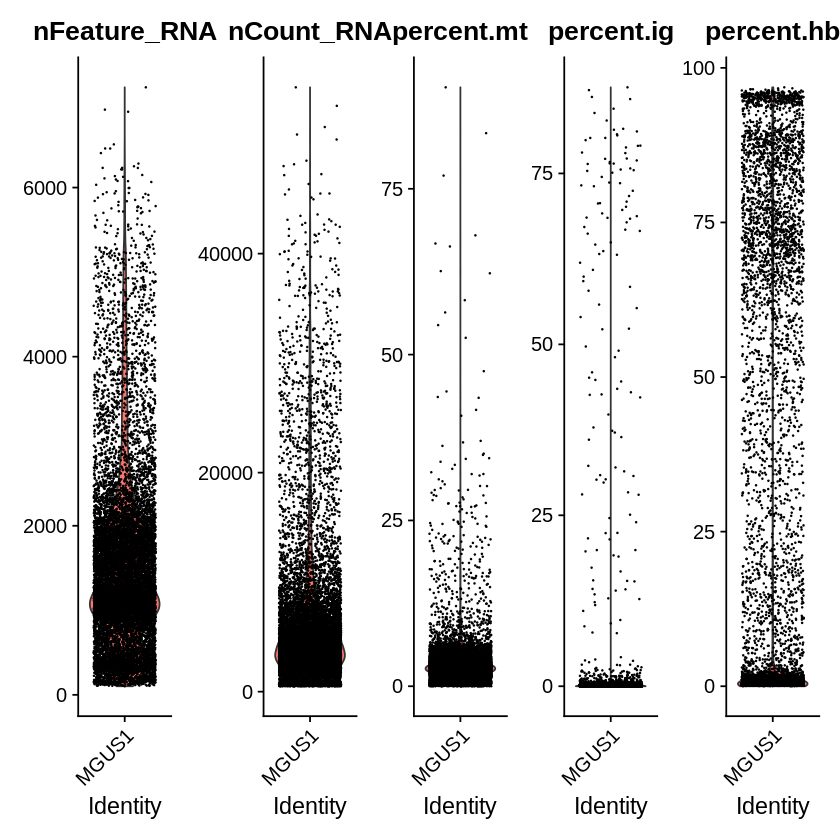

In [6]:
normal[["percent.mt"]] <- PercentageFeatureSet(normal, pattern = "^MT-")
normal[["percent.ig"]] <- PercentageFeatureSet(normal, pattern = "^IG")
normal[["percent.hb"]] <- PercentageFeatureSet(normal, pattern = "^HB")
VlnPlot(normal, features = c("nFeature_RNA", "nCount_RNA", "percent.mt","percent.ig","percent.hb"), ncol = 5)

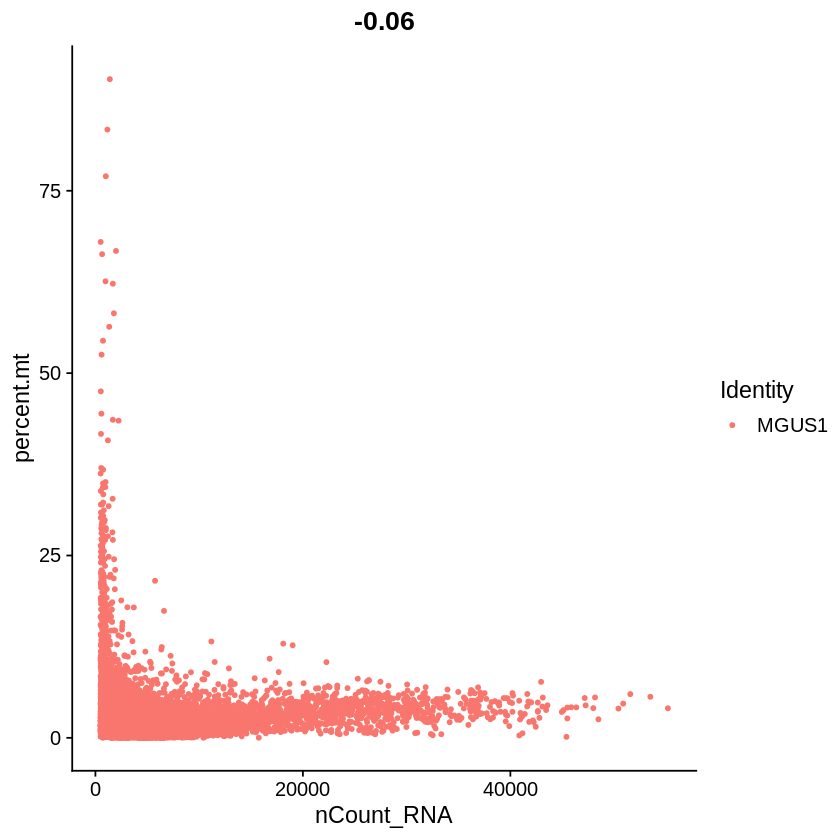

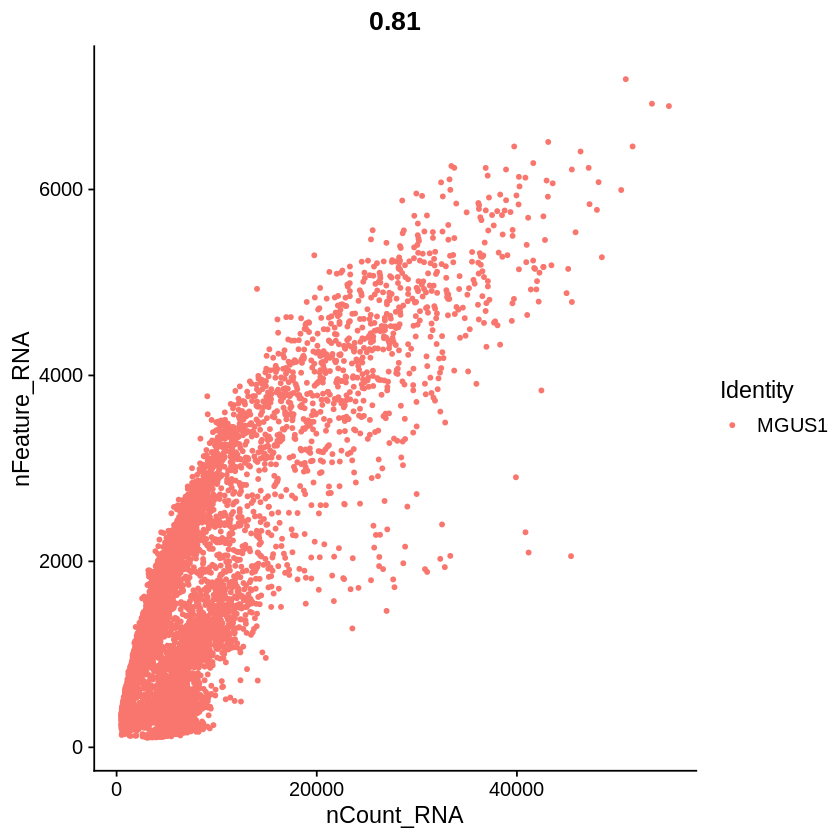

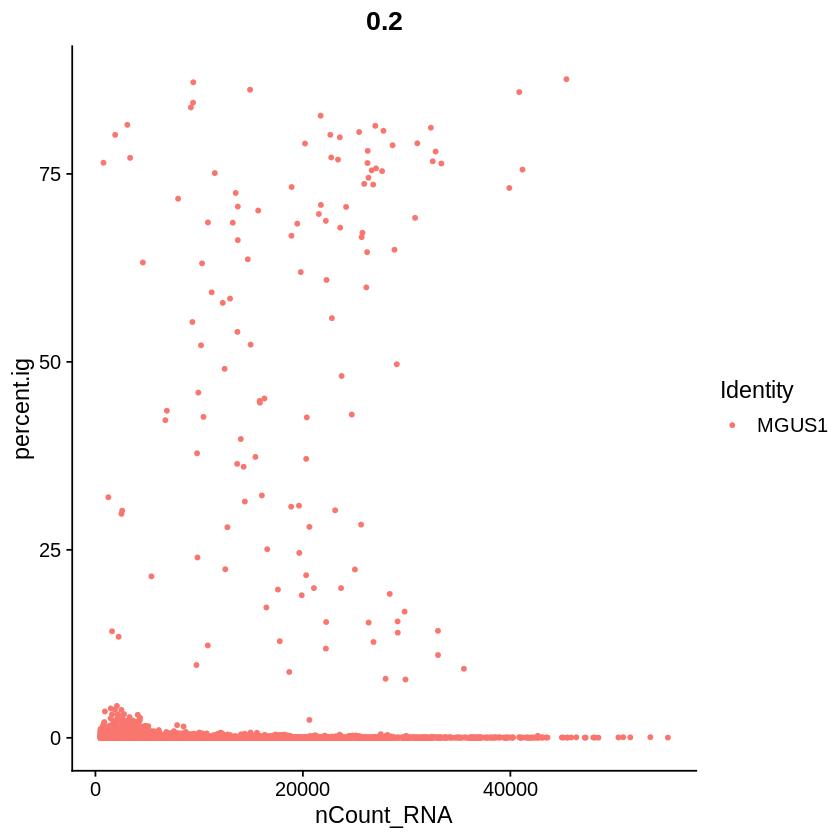

In [7]:
plot1 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot3 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "percent.ig")
plot1
plot2
plot3

In [9]:
normal <- subset(normal, subset = nFeature_RNA > 100 & nFeature_RNA < 4000 & percent.mt < 10 & percent.hb<1)
normal

An object of class Seurat 
21365 features across 8015 samples within 1 assay 
Active assay: RNA (21365 features, 0 variable features)

In [10]:
normal <- NormalizeData(normal, normalization.method = "LogNormalize", scale.factor = 10000)

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 246 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 246 rows containing missing values (geom_point).”


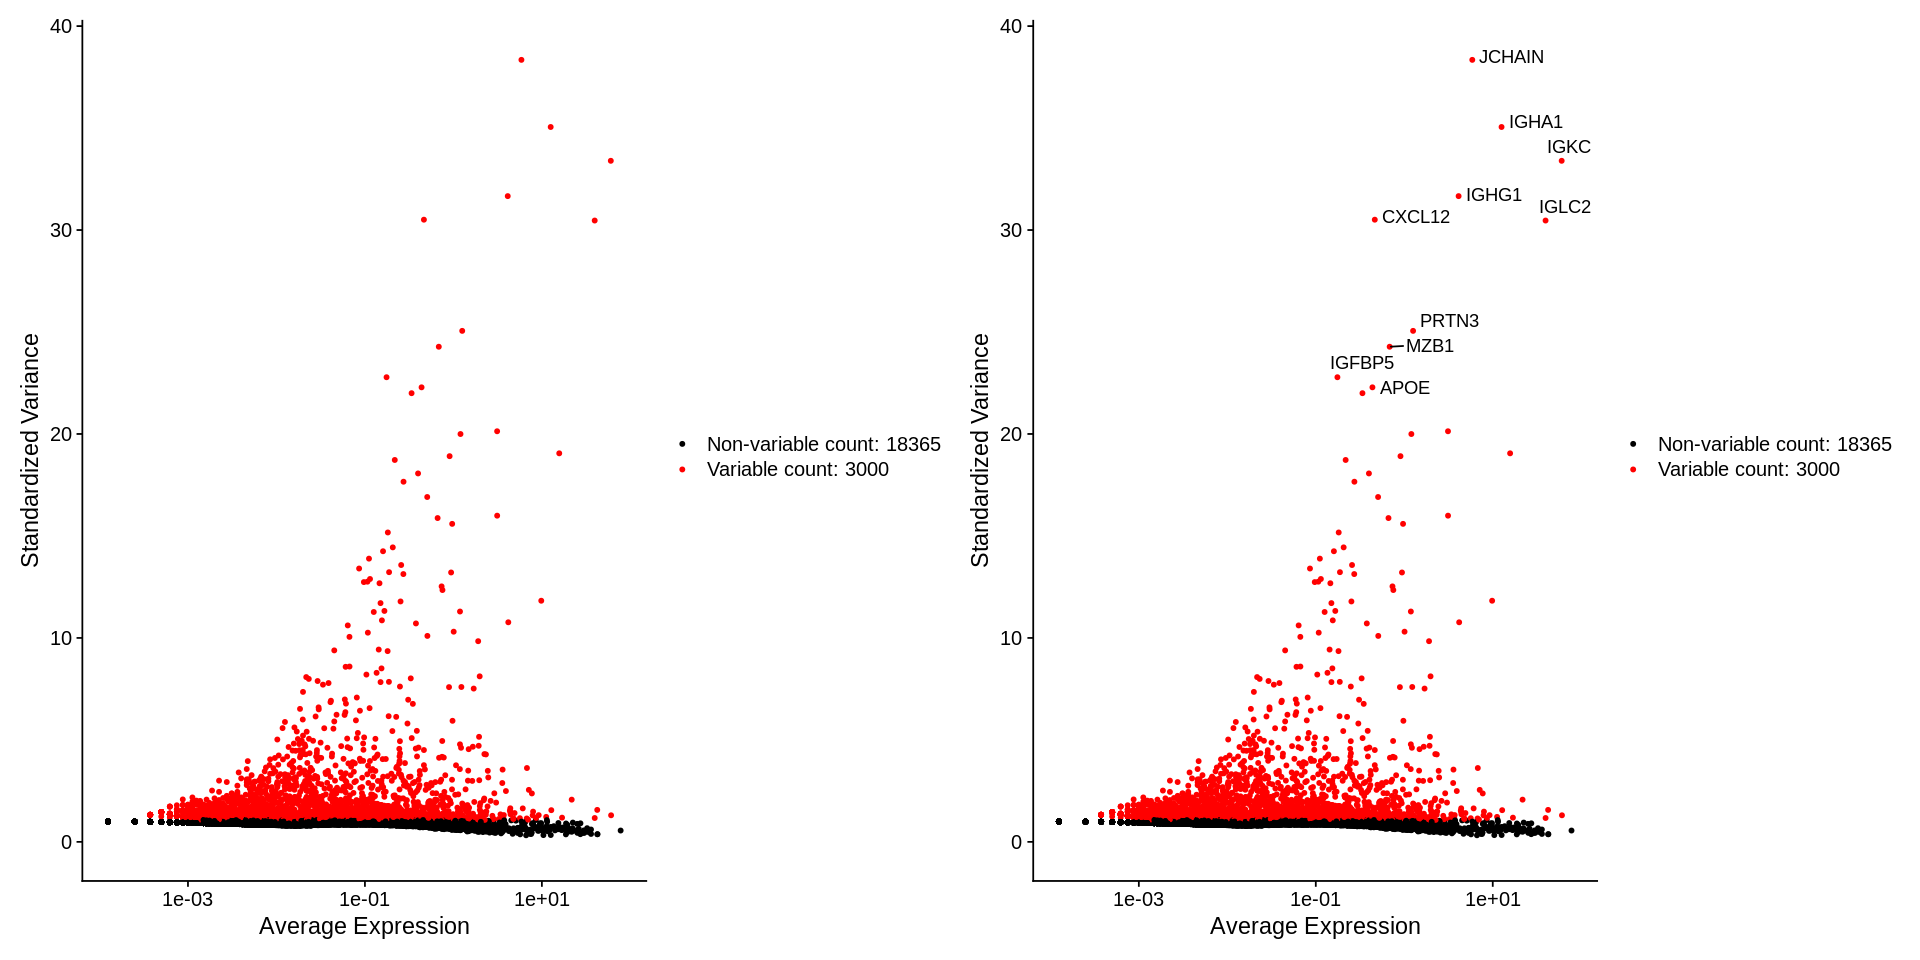

In [11]:
normal <- FindVariableFeatures(normal, selection.method = "vst", nfeatures = 3000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(normal), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(normal)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
options(repr.plot.height=8,repr.plot.width=16)
plot1+plot2

In [12]:
all.genes <- rownames(normal)
normal <- ScaleData(normal, features = all.genes)

Centering and scaling data matrix



In [13]:
length(VariableFeatures(object = normal))

[1] 3000

In [14]:
normal <- RunPCA(normal, features = VariableFeatures(object = normal))

PC_ 1 
Positive:  IL32, PCED1B-AS1, RPS4X, CD3D, TRBC2, LDHB, CD3E, RPSA, LTB, CD7 
	   LIME1, TRAC, EEF1B2, CD3G, ETS1, RPS6, IL7R, RPS5, NPM1, BCL11B 
	   LCK, CD2, LINC00861, GZMM, CD247, PRKCQ-AS1, HMGN1, CD69, CD27, CD52 
Negative:  CTSS, FCN1, IFI30, CST3, FTL, S100A9, FGL2, CYBB, LST1, LYZ 
	   SERPINA1, DUSP1, VCAN, CD14, AIF1, NAMPT, FOS, S100A8, DUSP6, SAT1 
	   RGS2, CLEC7A, NEAT1, MS4A6A, ZFP36, FPR1, S100A12, KCTD12, CD68, EGR1 
PC_ 2 
Positive:  IL32, CD3D, CD3E, CD52, TRAC, TRBC2, CD7, CD3G, IL7R, PCED1B-AS1 
	   LTB, BCL11B, LINC00861, GZMM, LCK, CD2, CD247, TRBC1, GIMAP5, PRKCQ-AS1 
	   TCF7, CD27, KLRB1, ETS1, CCR7, MAL, CCL5, LIME1, LAT, SPOCK2 
Negative:  STMN1, TYMS, PCLAF, TUBA1B, TOP2A, CDK1, MKI67, NUSAP1, TUBB, RRM2 
	   UHRF1, BIRC5, FABP5, ZWINT, UBE2C, CENPF, TK1, HMGN2, HIST1H4C, ASPM 
	   TPX2, PCNA, KIF11, MYBL2, H2AFZ, HMGB1, DUT, NCAPG, CKS2, GTSE1 
PC_ 3 
Positive:  PLPP3, VCAM1, NNMT, CXCL12, SELENOP, LPL, IGFBP5, TFPI, CALD1, LEPR 
	   APOE, FSTL1, E

In [15]:
options(repr.plot.height=8,repr.plot.width=8)

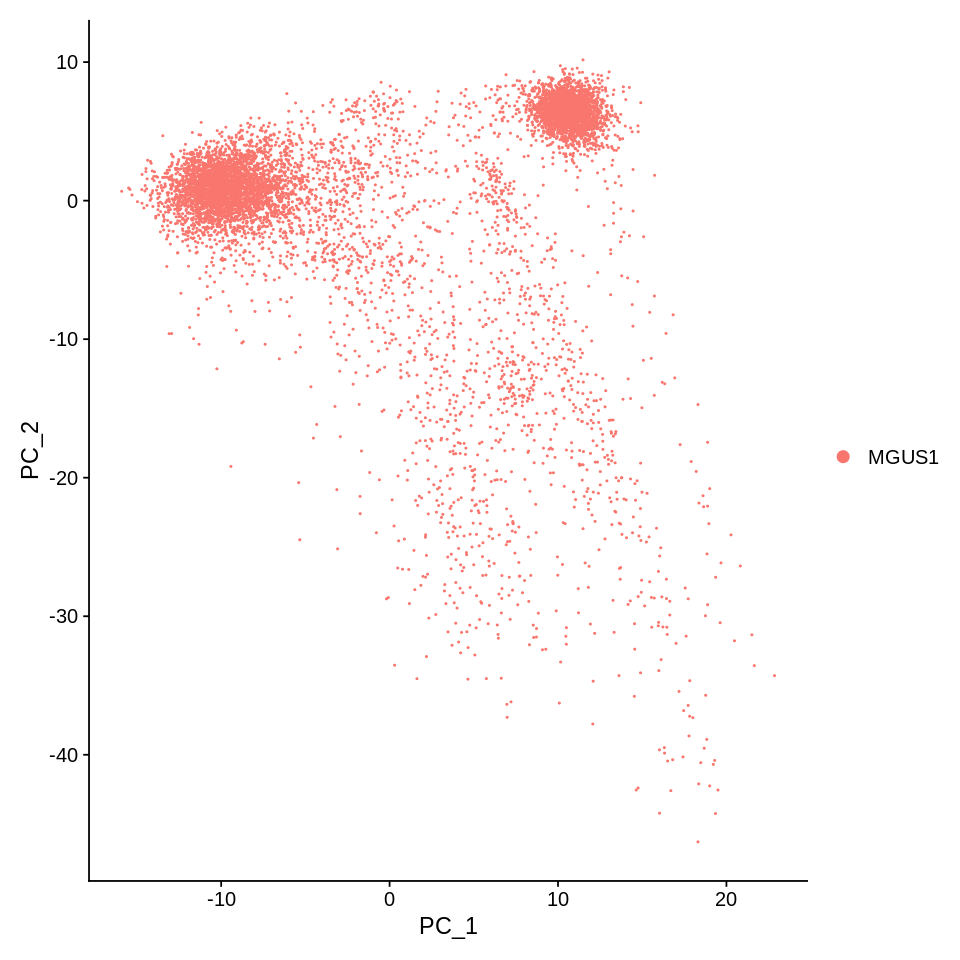

In [16]:
DimPlot(normal, reduction = "pca")

In [17]:
normal <- JackStraw(normal, num.replicate = 100)
normal <- ScoreJackStraw(normal, dims = 1:20)

Warning message:
“Removed 42000 rows containing missing values (geom_point).”


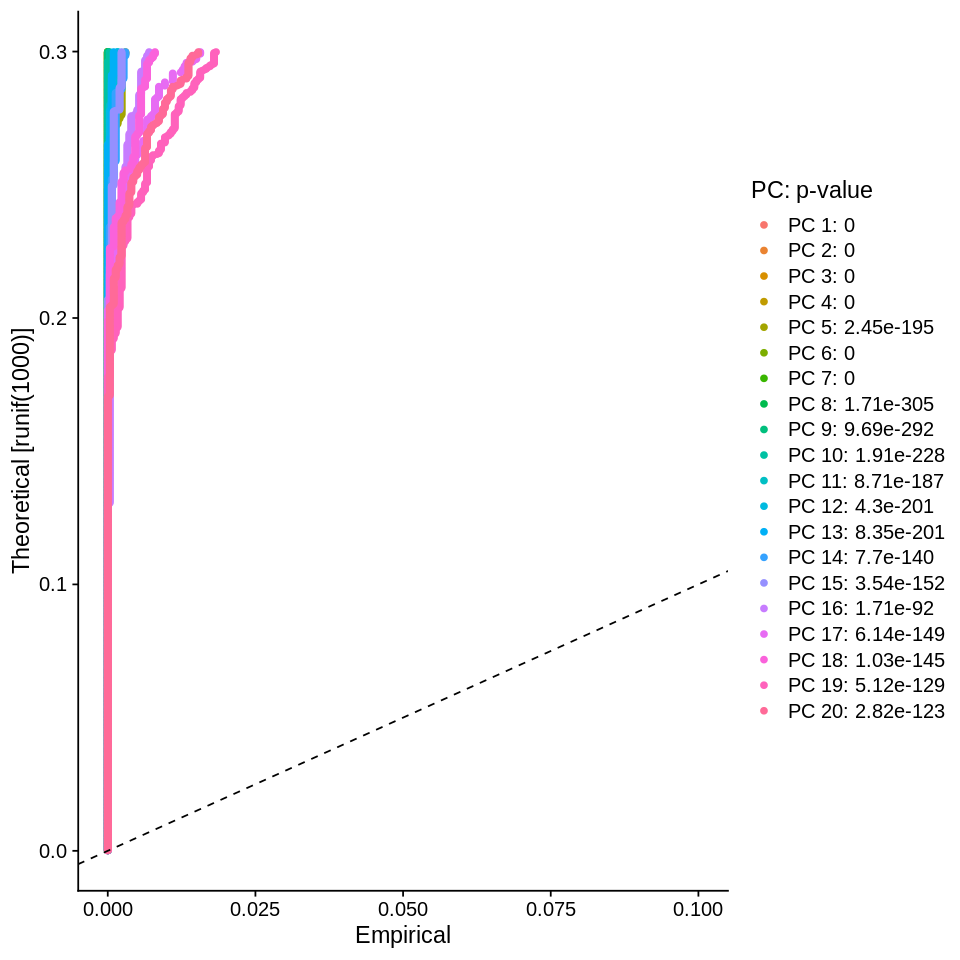

In [18]:
JackStrawPlot(normal, dims = 1:20)

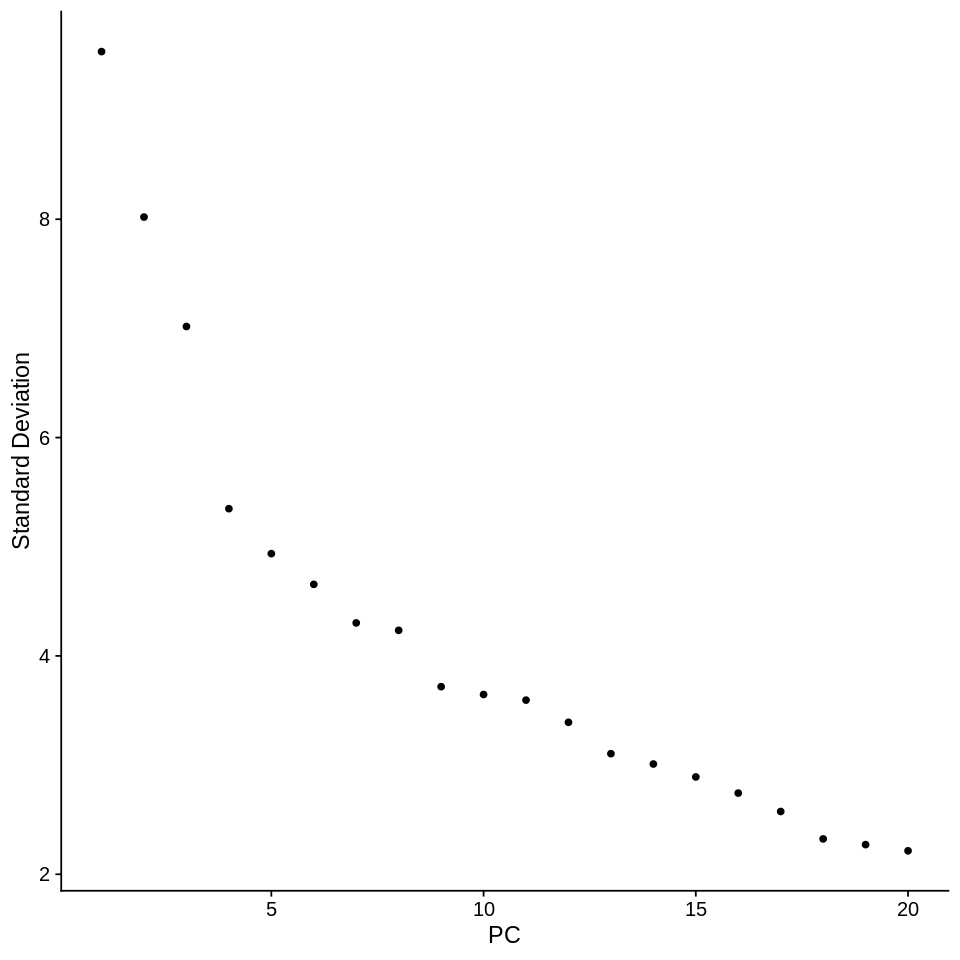

In [19]:
ElbowPlot(normal)

In [20]:
normal <- RunUMAP(normal, dims = 1:15)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
11:25:42 UMAP embedding parameters a = 0.9922 b = 1.112

11:25:42 Read 8015 rows and found 15 numeric columns

11:25:42 Using Annoy for neighbor search, n_neighbors = 30

11:25:42 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:25:43 Writing NN index file to temp file /tmp/RtmpZl82VK/file6c5ac58083098

11:25:43 Searching Annoy index using 1 thread, search_k = 3000

11:25:45 Annoy recall = 100%

11:25:45 Commencing smooth kNN distance calibration using 1 thread

11:25:46 Initializing fr

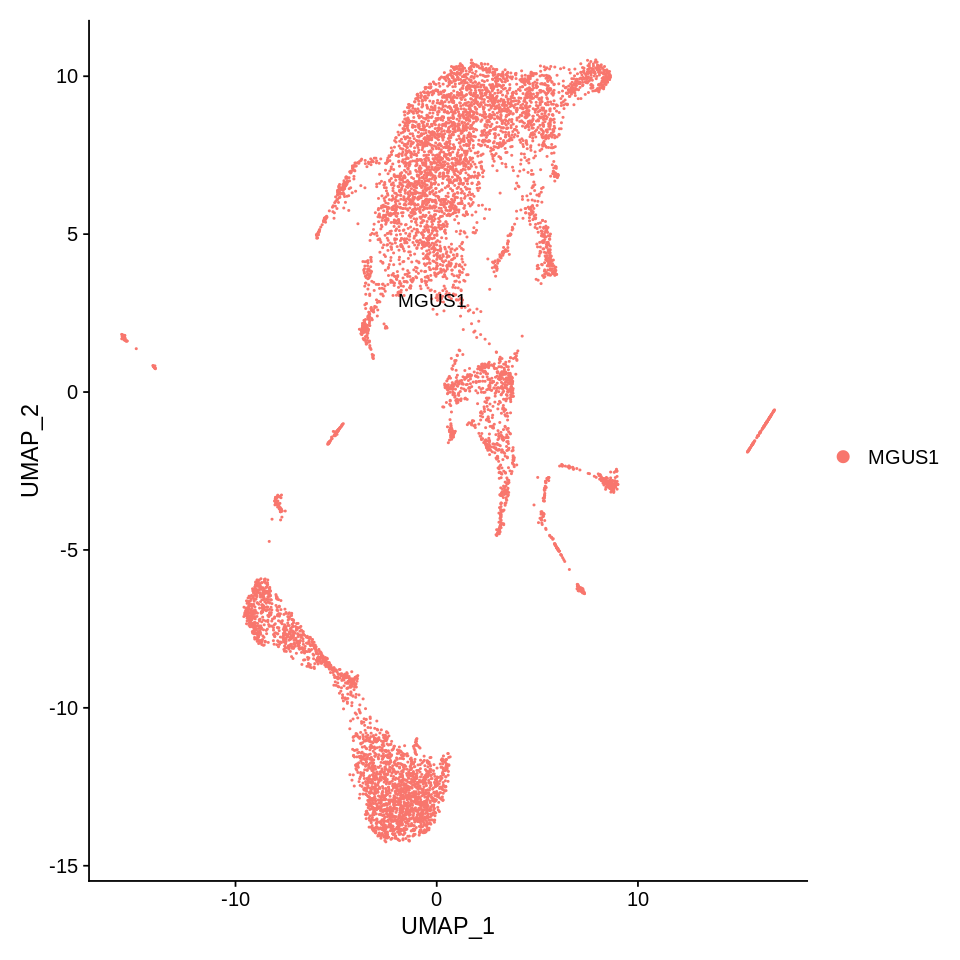

In [21]:
DimPlot(normal, reduction = "umap",label=T)

Loading required package: fields

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.7-0 (2021-06-25) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: viridis

Loading required package: viridisLite

See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 



[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."


Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Loading required package: ROCR

Loading required package: modes



NULL


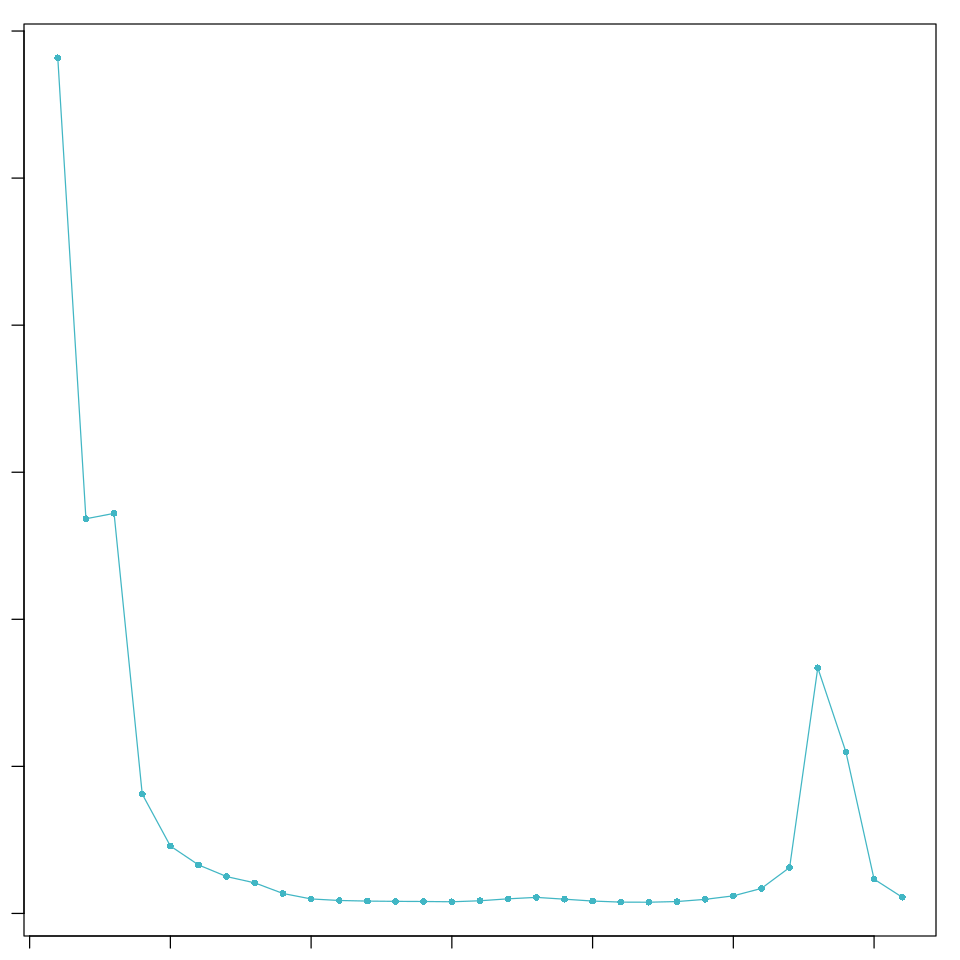

In [22]:
library(DoubletFinder)
sweep.res.list <- paramSweep_v3(normal, PCs = 1:15, sct = FALSE)
for(i in 1:length(sweep.res.list)){
  if(length(sweep.res.list[[i]]$pANN[is.nan(sweep.res.list[[i]]$pANN)]) != 0){
    if(i != 1){
      sweep.res.list[[i]] <- sweep.res.list[[i - 1]]
    }else{
      sweep.res.list[[i]] <- sweep.res.list[[i + 1]]
    }
  }
}
sweep.stats <- summarizeSweep(sweep.res.list, GT = FALSE)
bcmvn <- find.pK(sweep.stats)
pk_v <- as.numeric(as.character(bcmvn$pK))
pk_good <- pk_v[bcmvn$BCmetric==max(bcmvn$BCmetric)]
nExp_poi <- round(0.1*length(colnames(normal)))

In [23]:
normal <- doubletFinder_v3(normal, PCs = 1:15, pN = 0.25, pK = pk_good, nExp = nExp_poi, reuse.pANN = FALSE, sct = FALSE)

[1] "Creating 2672 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


In [24]:
colnames(normal@meta.data)[ncol(normal@meta.data)]="DoubletFinder"

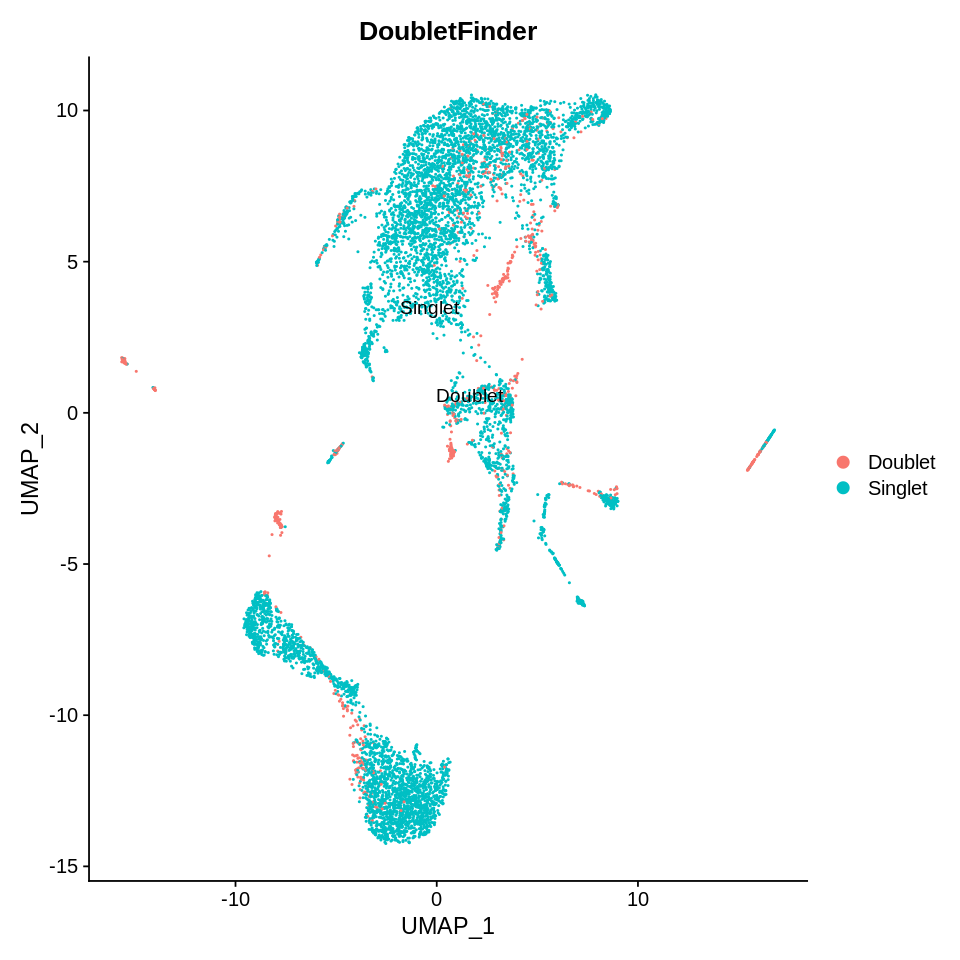

In [25]:
DimPlot(normal, reduction = "umap",label=T,group.by='DoubletFinder')

In [26]:
normal2<-subset(normal,DoubletFinder=='Singlet')

In [27]:
normal
normal2

An object of class Seurat 
21365 features across 8015 samples within 1 assay 
Active assay: RNA (21365 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

An object of class Seurat 
21365 features across 7213 samples within 1 assay 
Active assay: RNA (21365 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 544 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 544 rows containing missing values (geom_point).”


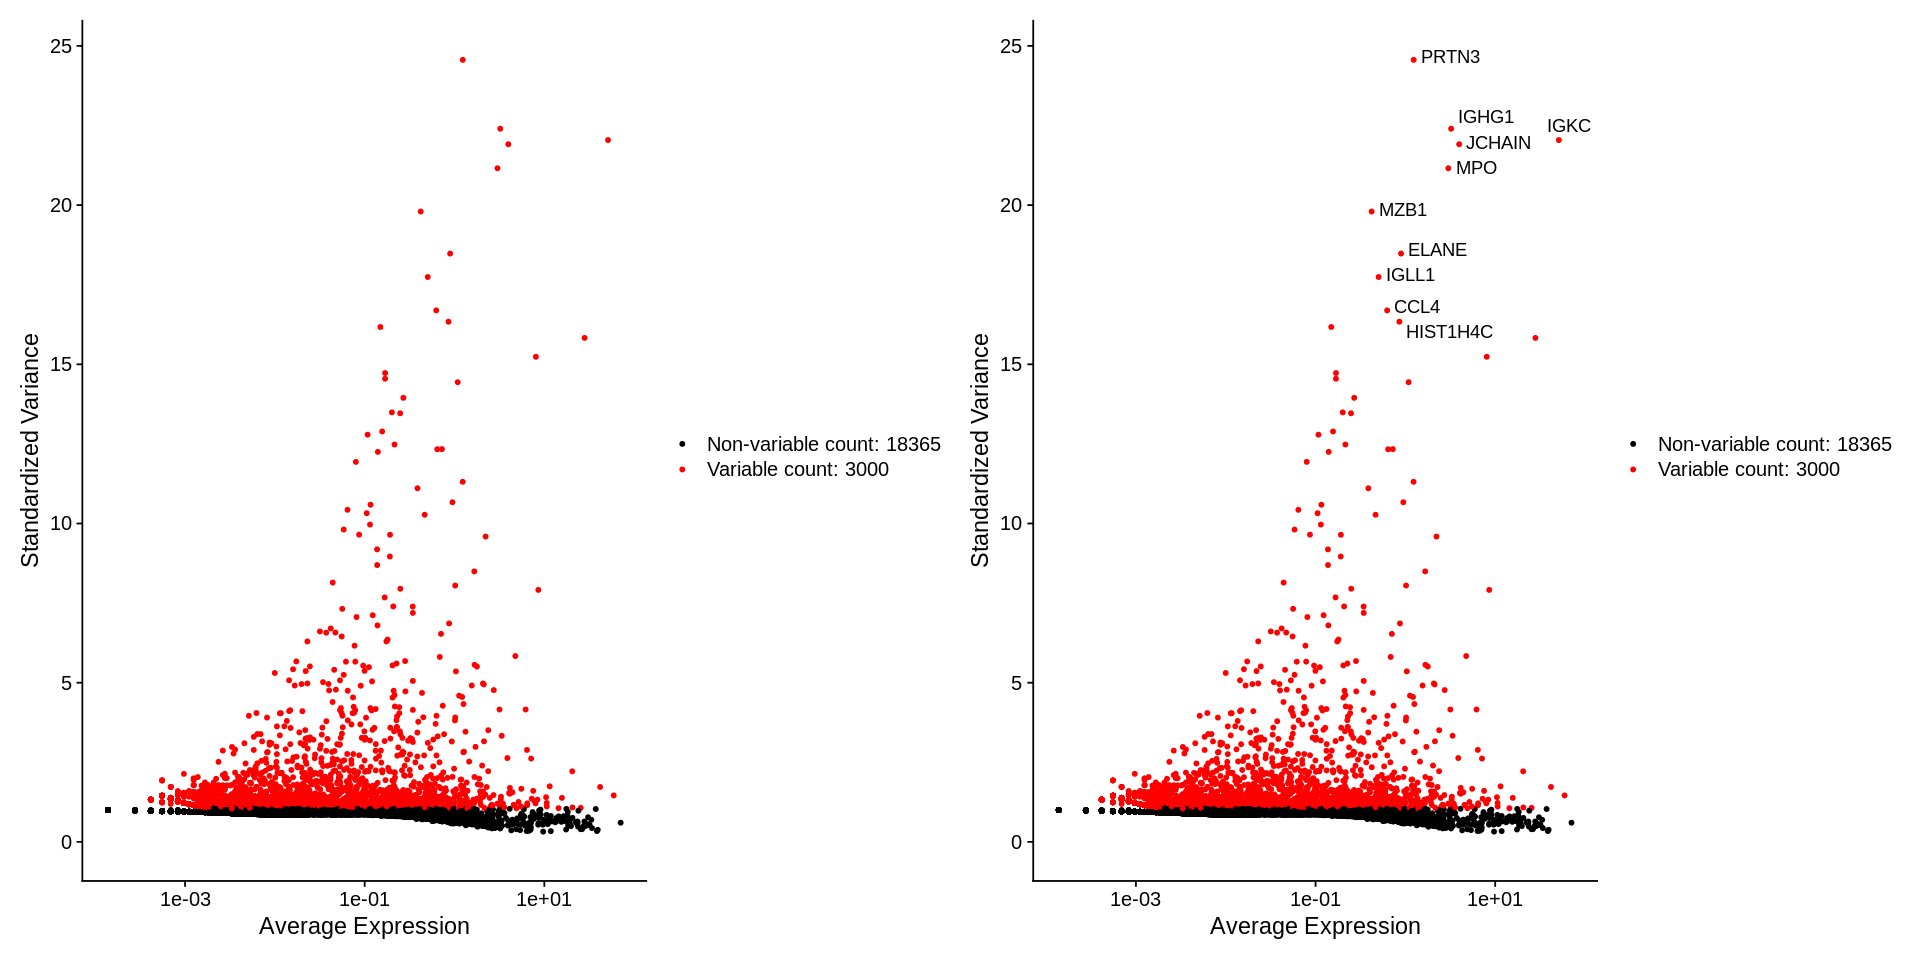

In [28]:
normal2 <- FindVariableFeatures(normal2, selection.method = "vst", nfeatures = 3000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(normal2), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(normal2)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
options(repr.plot.height=8,repr.plot.width=16)
plot1+plot2

In [29]:
all.genes <- rownames(normal2)
normal2 <- ScaleData(normal2, features = all.genes)

Centering and scaling data matrix



In [30]:
length(VariableFeatures(object = normal2))

[1] 3000

In [31]:
normal2 <- RunPCA(normal2, features = VariableFeatures(object = normal2))

PC_ 1 
Positive:  IL32, PCED1B-AS1, CD3D, RPL3, RPS4X, TRBC2, LTB, RPS3, CD3E, LDHB 
	   CD7, RPS18, RPSA, IL7R, TRAC, LIME1, CD3G, EEF1B2, RPS6, RPL5 
	   ETS1, RPS5, BCL11B, NPM1, LINC00861, RPL10A, LCK, CD2, GZMM, PRKCQ-AS1 
Negative:  FCN1, CTSS, IFI30, MNDA, CST3, TYMP, S100A9, LYZ, CYBB, FGL2 
	   VCAN, LST1, SERPINA1, DUSP1, FOS, S100A8, CD14, AIF1, NAMPT, SAT1 
	   DUSP6, RGS2, NEAT1, MS4A6A, CLEC7A, ZFP36, S100A12, FCER1G, LGALS1, FPR1 
PC_ 2 
Positive:  STMN1, TYMS, PCLAF, UHRF1, RRM2, TOP2A, CDK1, MKI67, NUSAP1, TUBA1B 
	   TUBB, BIRC5, FABP5, TK1, ZWINT, HIST1H4C, UBE2C, CENPF, PCNA, IGLL1 
	   MPO, TPX2, HMGN2, CDCA7, ASPM, MYBL2, MCM7, GINS2, HELLS, RNASE2 
Negative:  IL32, CD3D, CD52, CD3E, TRAC, CD7, CD3G, TRBC2, PCED1B-AS1, IL7R 
	   BCL11B, GZMM, LINC00861, LCK, CD2, CD247, ETS1, LTB, GIMAP5, TRBC1 
	   CCL5, KLRB1, GZMA, LIME1, CD27, LAT, TCF7, KLRK1, SAMD3, SPOCK2 
PC_ 3 
Positive:  LILRA4, CLEC4C, SCT, SPIB, SERPINF1, TPM2, NIBAN3, IL3RA, TCF4, CCDC50 
	   JCHAIN, 

In [32]:
normal2 <- JackStraw(normal2, num.replicate = 100)
normal2 <- ScoreJackStraw(normal2, dims = 1:20)

Warning message:
“Removed 42011 rows containing missing values (geom_point).”


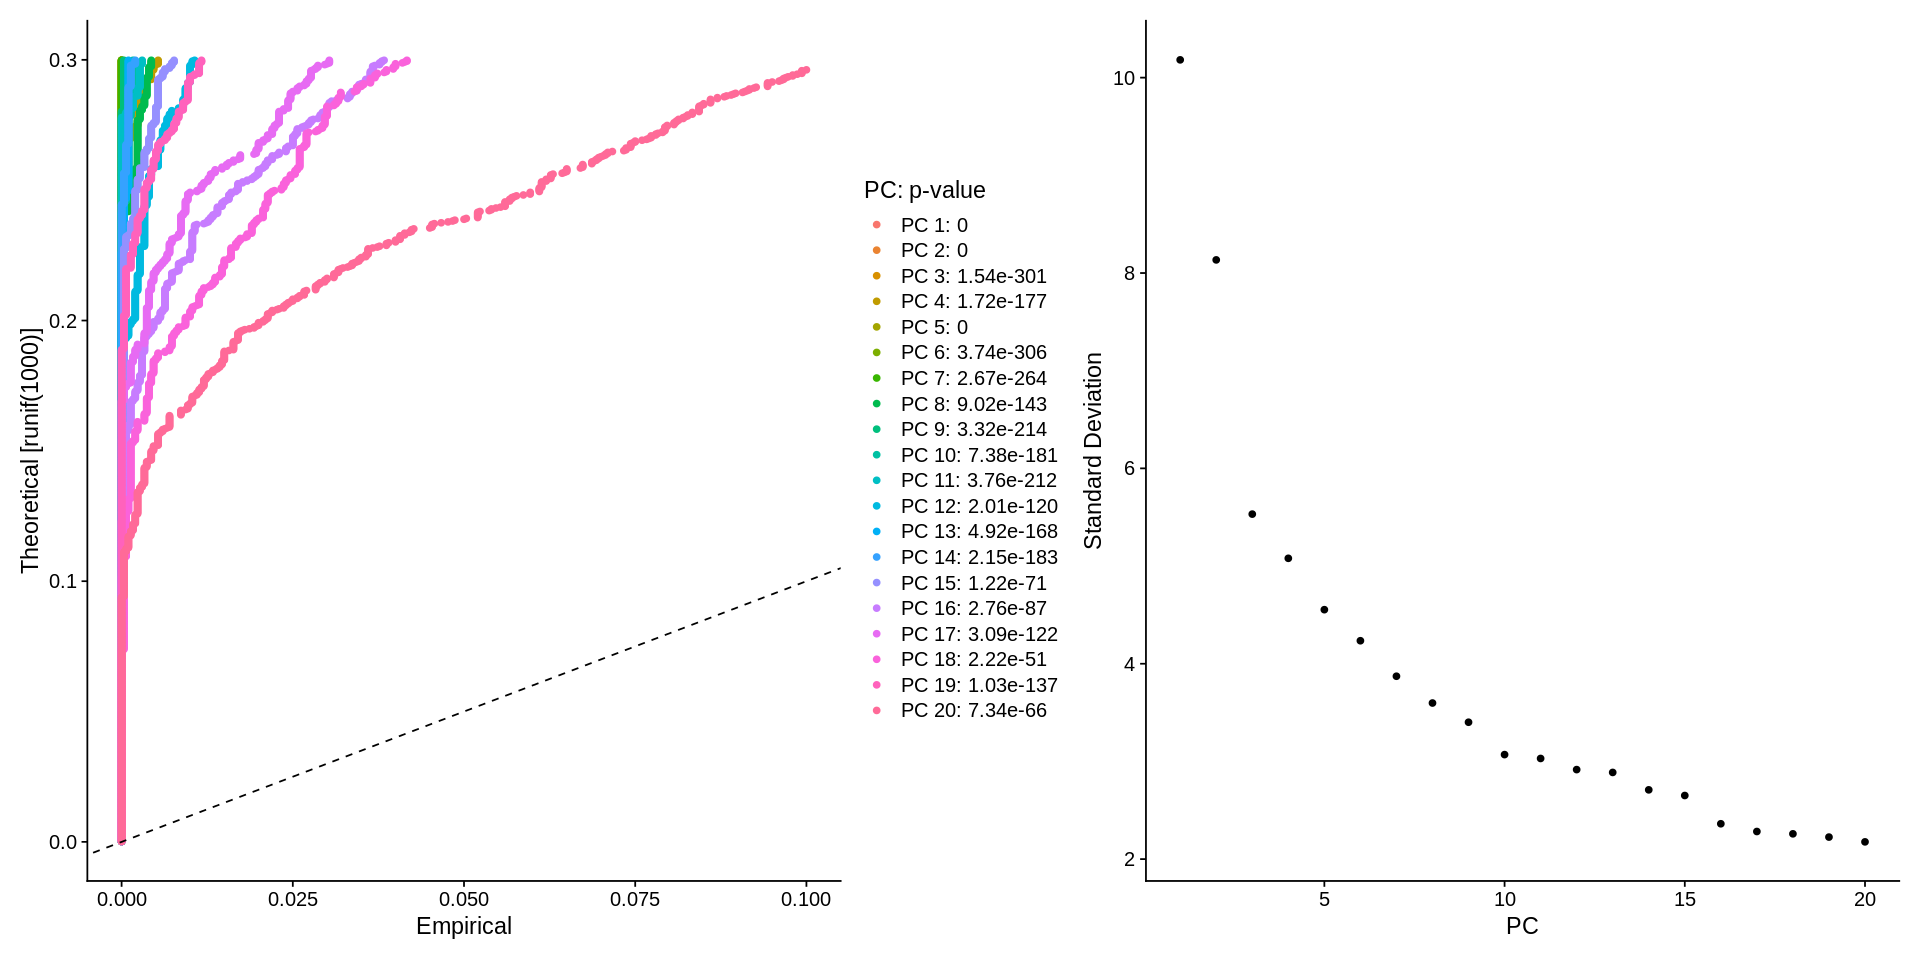

In [33]:
jplot<-JackStrawPlot(normal2, dims = 1:20)
eplot<-ElbowPlot(normal2)
options(repr.plot.height=8,repr.plot.width=16)
jplot+eplot

In [38]:
normal2 <- FindNeighbors(normal2, dims = 1:15)
normal2 <- FindClusters(normal2, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7213
Number of edges: 255619

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9037
Number of communities: 16
Elapsed time: 0 seconds


In [39]:
normal2 <- RunUMAP(normal2, dims = 1:15)

11:33:12 UMAP embedding parameters a = 0.9922 b = 1.112

11:33:12 Read 7213 rows and found 15 numeric columns

11:33:12 Using Annoy for neighbor search, n_neighbors = 30

11:33:12 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:33:13 Writing NN index file to temp file /tmp/RtmpZl82VK/file6c5ac639230c2

11:33:13 Searching Annoy index using 1 thread, search_k = 3000

11:33:14 Annoy recall = 100%

11:33:15 Commencing smooth kNN distance calibration using 1 thread

11:33:15 Initializing from normalized Laplacian + noise

11:33:15 Commencing optimization for 500 epochs, with 301576 positive edges

11:33:22 Optimization finished



In [40]:
options(repr.plot.height=8,repr.plot.width=8)

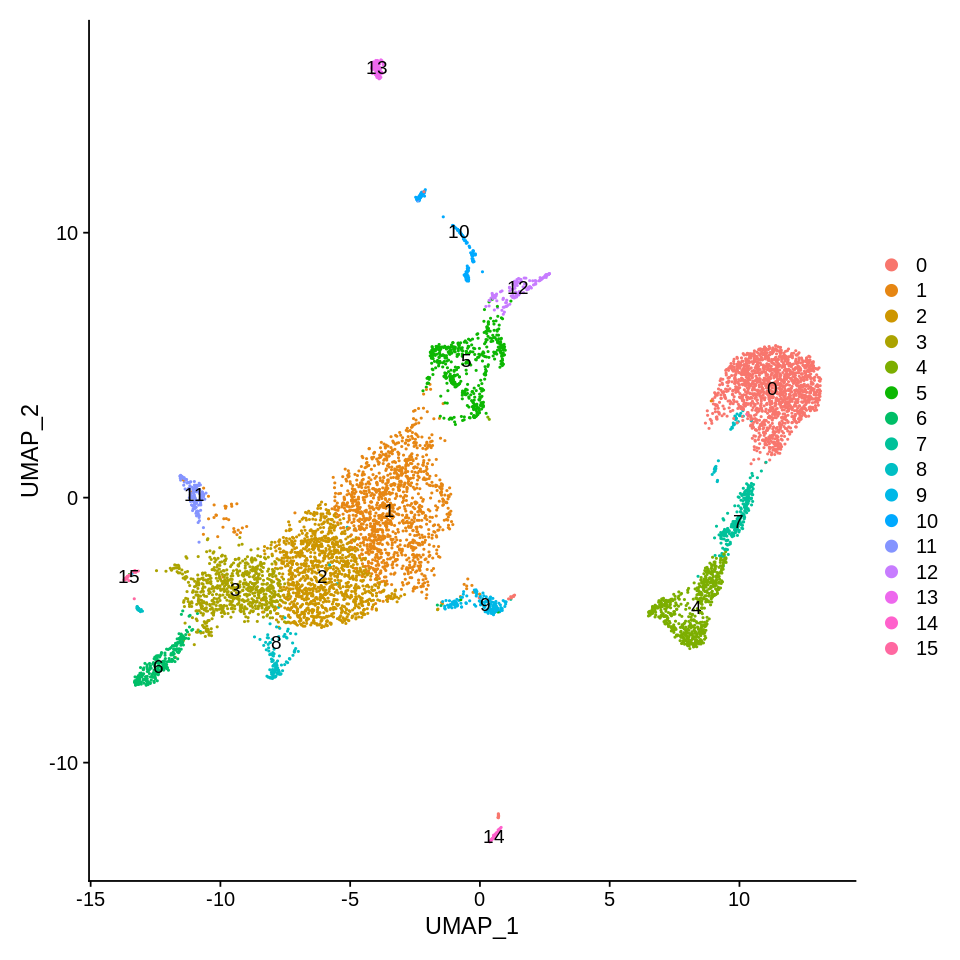

In [41]:
DimPlot(normal2, reduction = "umap",label=T)

In [42]:
load('/together_sdc/zhoujiaqi/sc0418/RNA/imgs.xxy/HPCA.Rdata')
load('/together_sdc/zhoujiaqi/sc0418/RNA/imgs.xxy/NHD.RData')
library(Seurat)
library(SingleR)
library(viridis)
library(pheatmap)

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4


Attaching package: ‘stats4’


The following object is masked from ‘package:spam’:

    mle


Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:spam’:

    cbind, rbind


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filte

In [43]:
#进行singleR注释
AL_for_SingleR <- GetAssayData(normal2, slot="data") ##获取标准化矩阵

In [44]:
#先从cluster分辨率注释
clusterann<-SingleR(AL_for_SingleR, hpca.se, method="cluster", clusters=normal2@meta.data$seurat_clusters,labels=hpca.se$label.main)
#　save(clusterann,file="/together_sdb/zhoujiaqi/sc0418/RNA/imgs.xxy/AL1.M/dim8_res0.8/clusterann.Rdata")
clusterann
clusterann<-as.data.frame(row.names=clusterann@rownames,clusterann$labels)

Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 2”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 26”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 7”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 8”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 2”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 88”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 17”
Warning message:
“Argument 'center' should be

DataFrame with 16 rows and 5 columns
                            scores     first.labels       tuning.scores
                          <matrix>      <character>         <DataFrame>
0   0.268583:0.627858:0.615445:...          T_cells 0.801429: 0.7330831
1   0.243344:0.560799:0.694831:...         Monocyte 0.618238: 0.2878149
2   0.247491:0.567267:0.679055:...         Monocyte 0.644783: 0.2321564
3   0.259041:0.568968:0.657078:...         Monocyte 0.641575:-0.0917122
4   0.262714:0.596816:0.594808:...          NK_cell 0.803525: 0.7377050
...                            ...              ...                 ...
11  0.276781:0.608043:0.613473:...         Monocyte 0.491444:-0.0127264
12  0.377852:0.544888:0.617437:...              CMP 0.852994: 0.8012978
13  0.281155:0.617464:0.605039:... Pre-B_cell_CD34- 0.321341: 0.1753663
14  0.298861:0.597024:0.528958:...           B_cell 0.395185: 0.2517104
15  0.250035:0.462734:0.506749:...         Monocyte 0.240353: 0.1740281
              labels    pru

In [45]:
AL.nhsc <- SingleR(test = AL_for_SingleR, ref= nhd.se, labels = nhd.se$label.main) 

Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 29”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 6”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 21”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 24”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 4”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 10”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 5”
Warning message:
“Argument 'center' should b

In [46]:
meta=normal2@meta.data
table(AL.nhsc$labels,meta$seurat_clusters)
normal2@meta.data$labels <-AL.nhsc$labels

                 
                     0    1    2    3    4    5    6    7    8    9   10   11
  B cells            0    0    0    0    0    0    0    0    0    0   87    0
  Basophils          1    0    0    0    0    0    0    0    0    0   16    0
  CD4+ T cells    1100    0    0    0    0    0    0    1   26    0    0    0
  CD8+ T cells     425    0    0    0  200    1    0  218    8    0    0    0
  CMPs               8    1    0    0    0   88    0    0    0    0    2    0
  Dendritic cells    0    0    0    0    0   11    0    0    0    0    0   65
  Eosinophils        0    2    0    0    0    0    0    0    0    0   10    0
  Erythroid cells    0    0    0    0    0    3    0    0    0    0    0    0
  GMPs               0    0    0    0    0   25    0    0    0    0    0    0
  Granulocytes      40    4    0    0   14   11    1    7    2   30    8    0
  HSCs               0    0    0    0    0    0    0    0    0    0   12    0
  Megakaryocytes     0    0    0    0    0    

In [47]:
options(repr.plot.height=9,repr.plot.width=16)

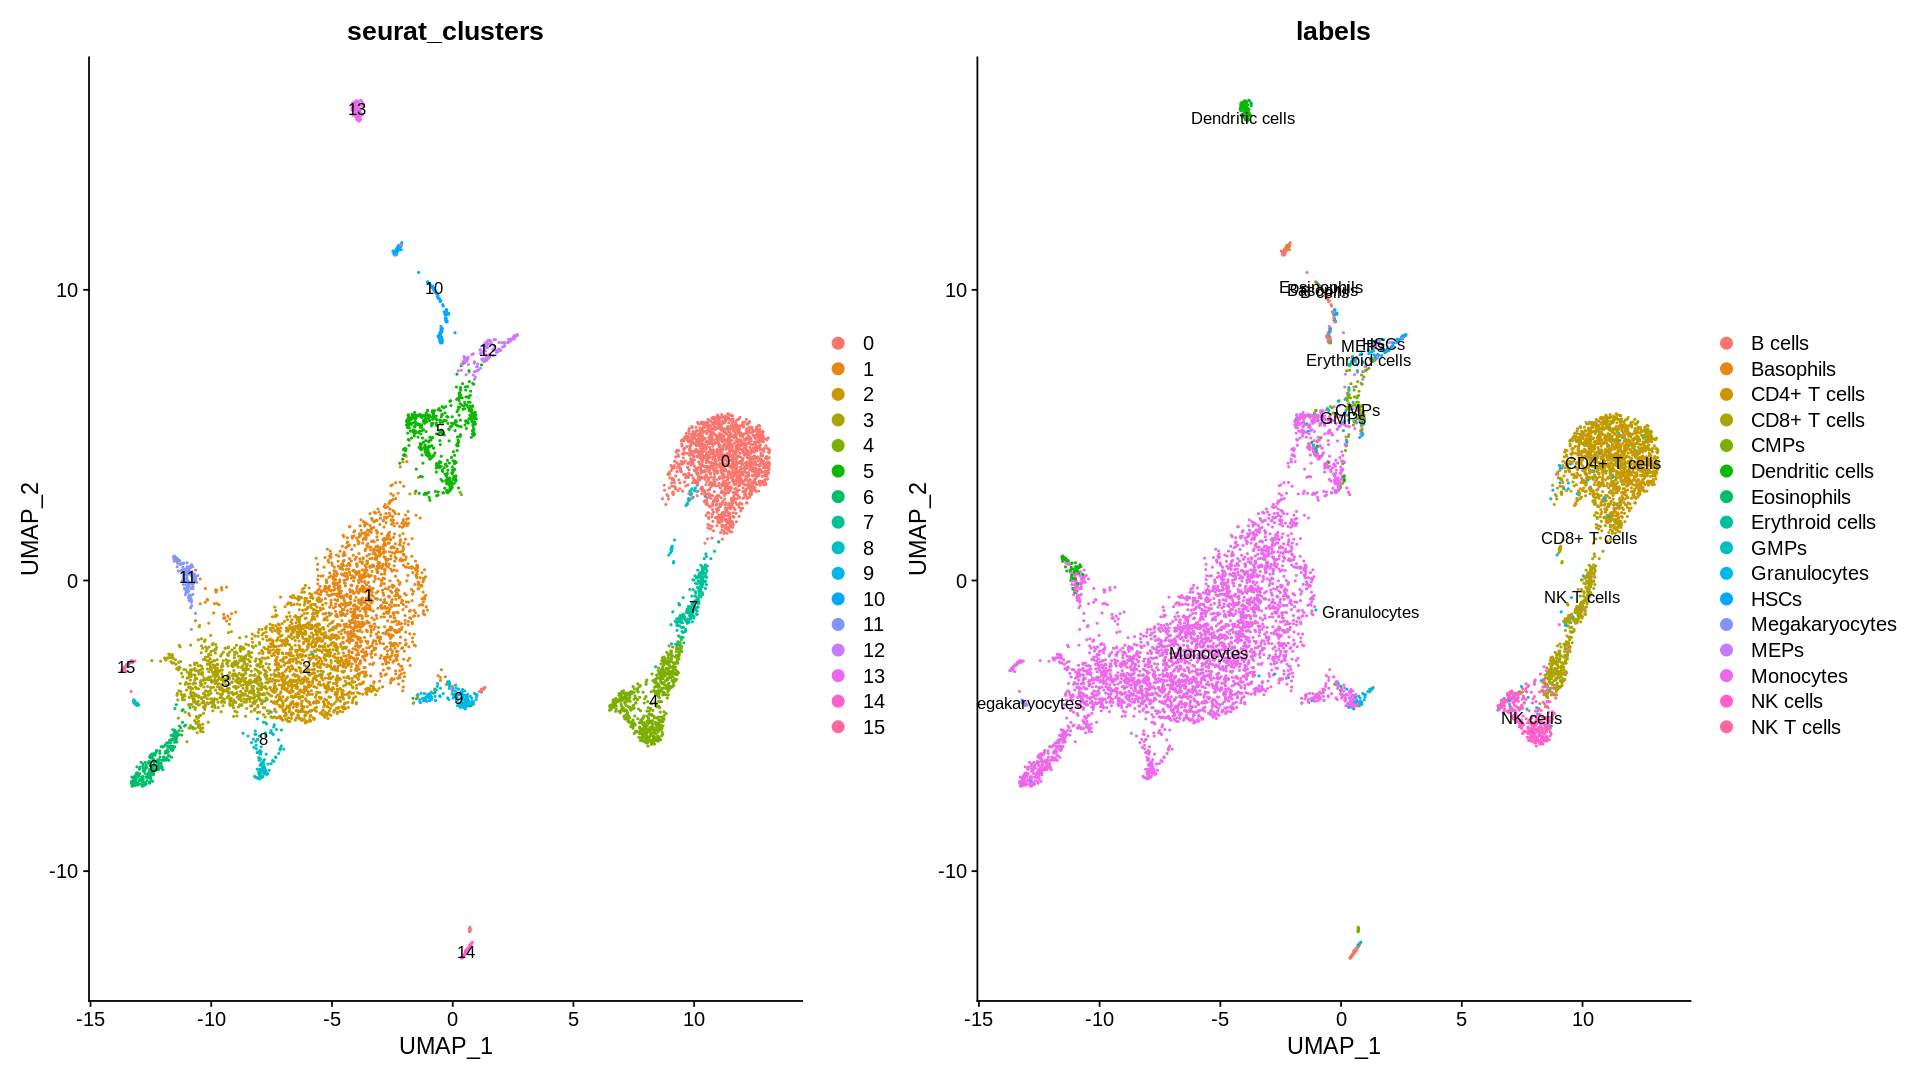

In [48]:
label_plot<-DimPlot(normal2, group.by = c("seurat_clusters","labels"),reduction = "umap",label = TRUE,label.size =3.5)
label_plot

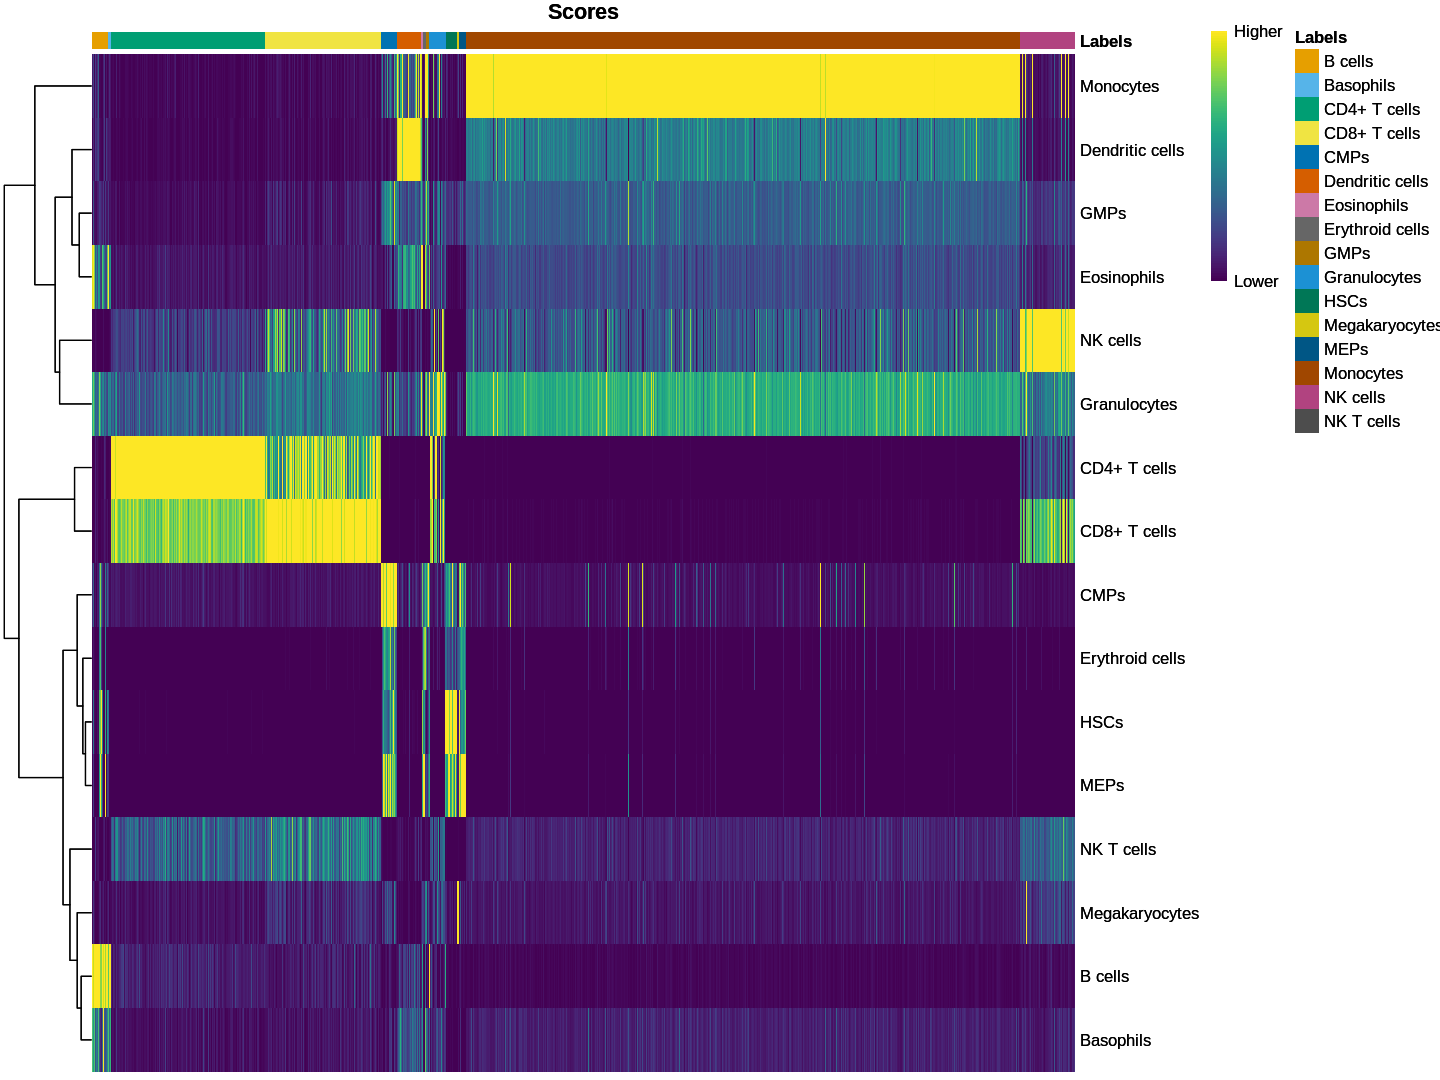

In [49]:
options(repr.plot.height=9,repr.plot.width=12)
plotScoreHeatmap(AL.nhsc)

In [50]:
options(repr.plot.height=9,repr.plot.width=16)

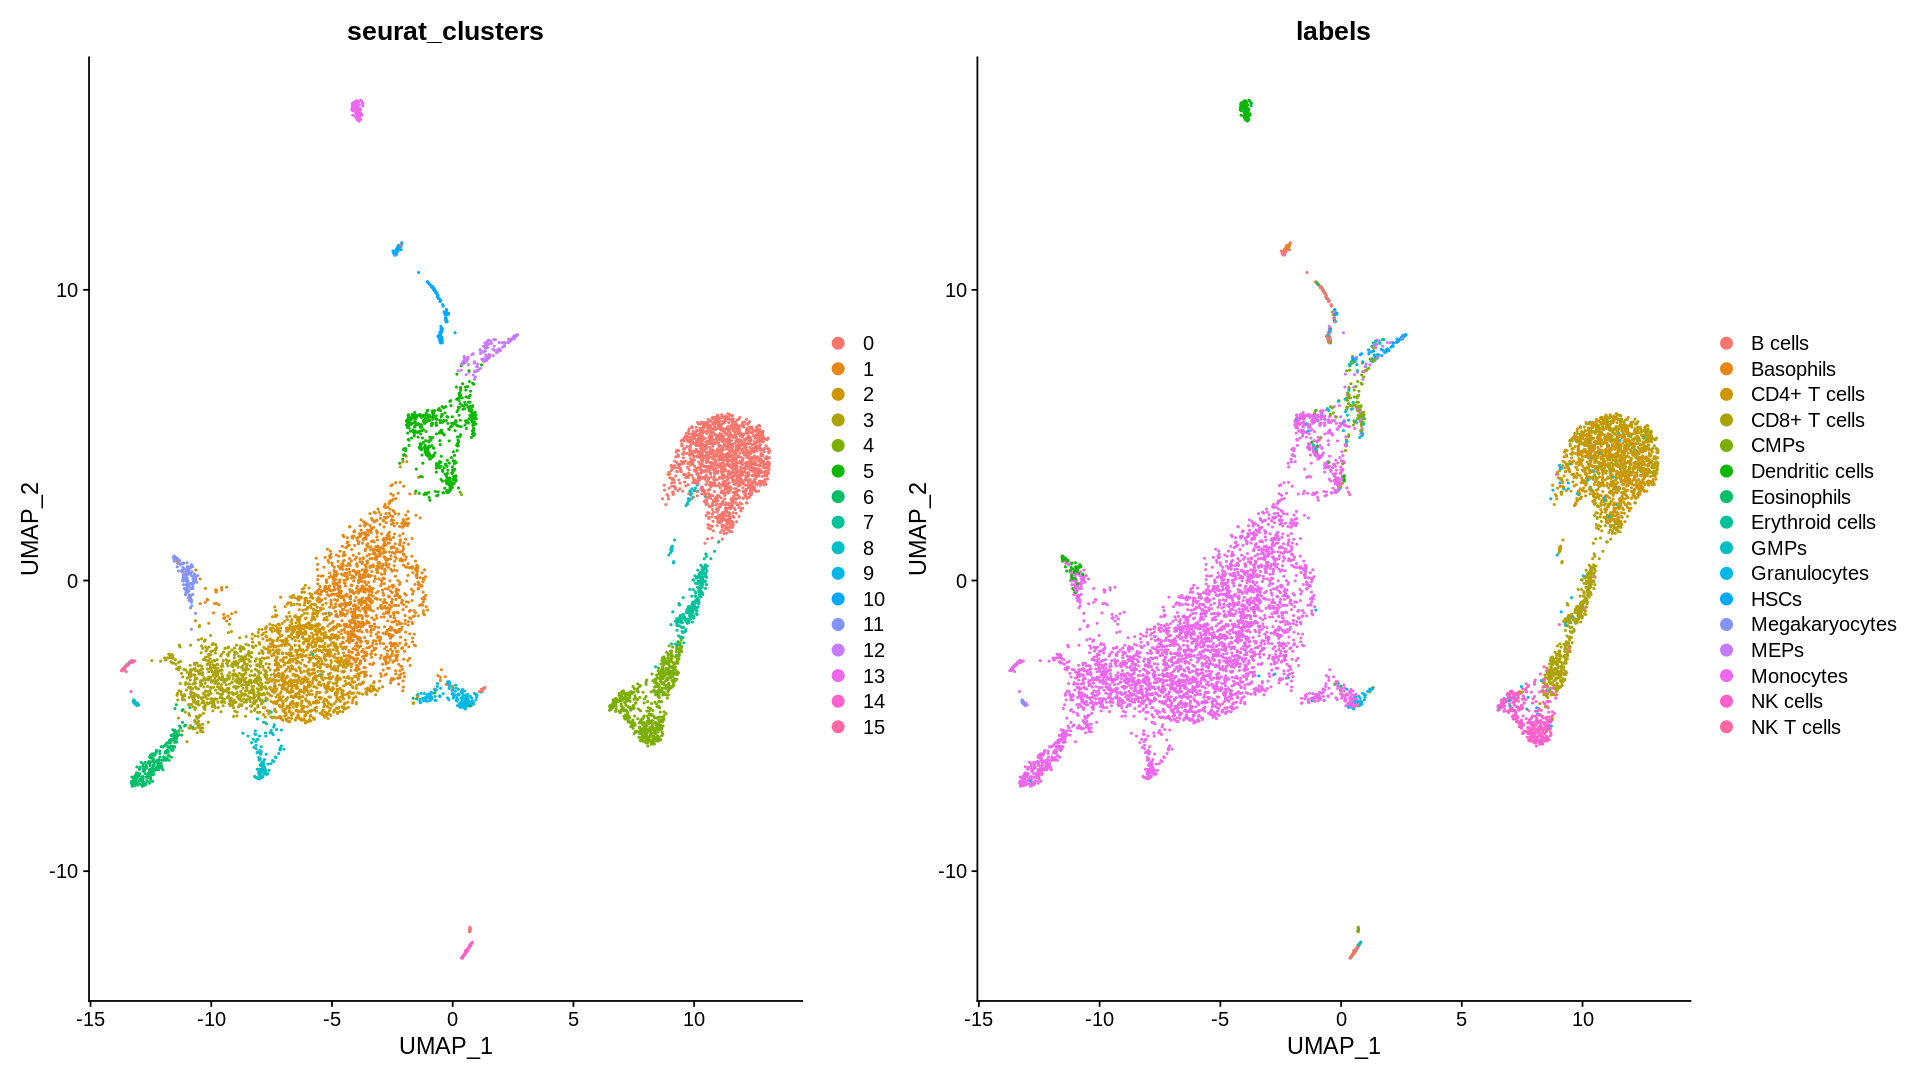

In [51]:
unlabel_plot<-DimPlot(normal2, group.by = c("seurat_clusters","labels"),reduction = "umap")
unlabel_plot

In [52]:
AL.hesc <- SingleR(test = AL_for_SingleR, ref= hpca.se, labels = hpca.se$label.main) 

Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 2”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 26”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 7”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 8”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 2”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 88”
Warning message:
“Argument 'center' should be of the same length as number of rows of 'x'. Use of a scalar value is deprecated: 1 != 17”
Warning message:
“Argument 'center' should be

In [53]:
meta=normal2@meta.data
table(AL.hesc$labels,meta$seurat_clusters)
normal2@meta.data$labels <-AL.hesc$labels

                  
                      0    1    2    3    4    5    6    7    8    9   10   11
  B_cell              1    0    0    0    0    0    0    0    0    0   49    0
  BM                  1    0    0    0    0    1    0    0    1    0    1    0
  CMP                 5    0    0    0    0   22    0    0    0    0    0    0
  DC                  0    0    0    0    0    0    0    0    0    0    0    2
  GMP                 0    0    0    0    0   82    0    0    0    0    0    0
  HSC_-G-CSF          5   27    0    0    3    2    0    2    2   22    1    0
  HSC_CD34+           1    0    0    0    0    0    0    0    0    0    0    0
  Macrophage          0    0    0    0    0    1    0    0    0    0    0    0
  MEP                 0    0    0    0    0    1    0    0    0    0    0    0
  Monocyte            0 1172 1166  732    0   55  254    0  109    4    0  129
  Myelocyte           0    3    0    0    0   10    0    0    0   85    0    0
  Neutrophils         2    4    1

In [54]:
type<-as.data.frame(AL.hesc$labels)
count<-table(type)
count

type
          B_cell               BM              CMP               DC 
              95                5              121                5 
             GMP       HSC_-G-CSF        HSC_CD34+       Macrophage 
             106               65                1               25 
             MEP         Monocyte        Myelocyte      Neutrophils 
              21             3643               98                8 
         NK_cell        Platelets Pre-B_cell_CD34- Pro-B_cell_CD34+ 
             520               17              313               96 
   Pro-Myelocyte          T_cells 
             182             1892 

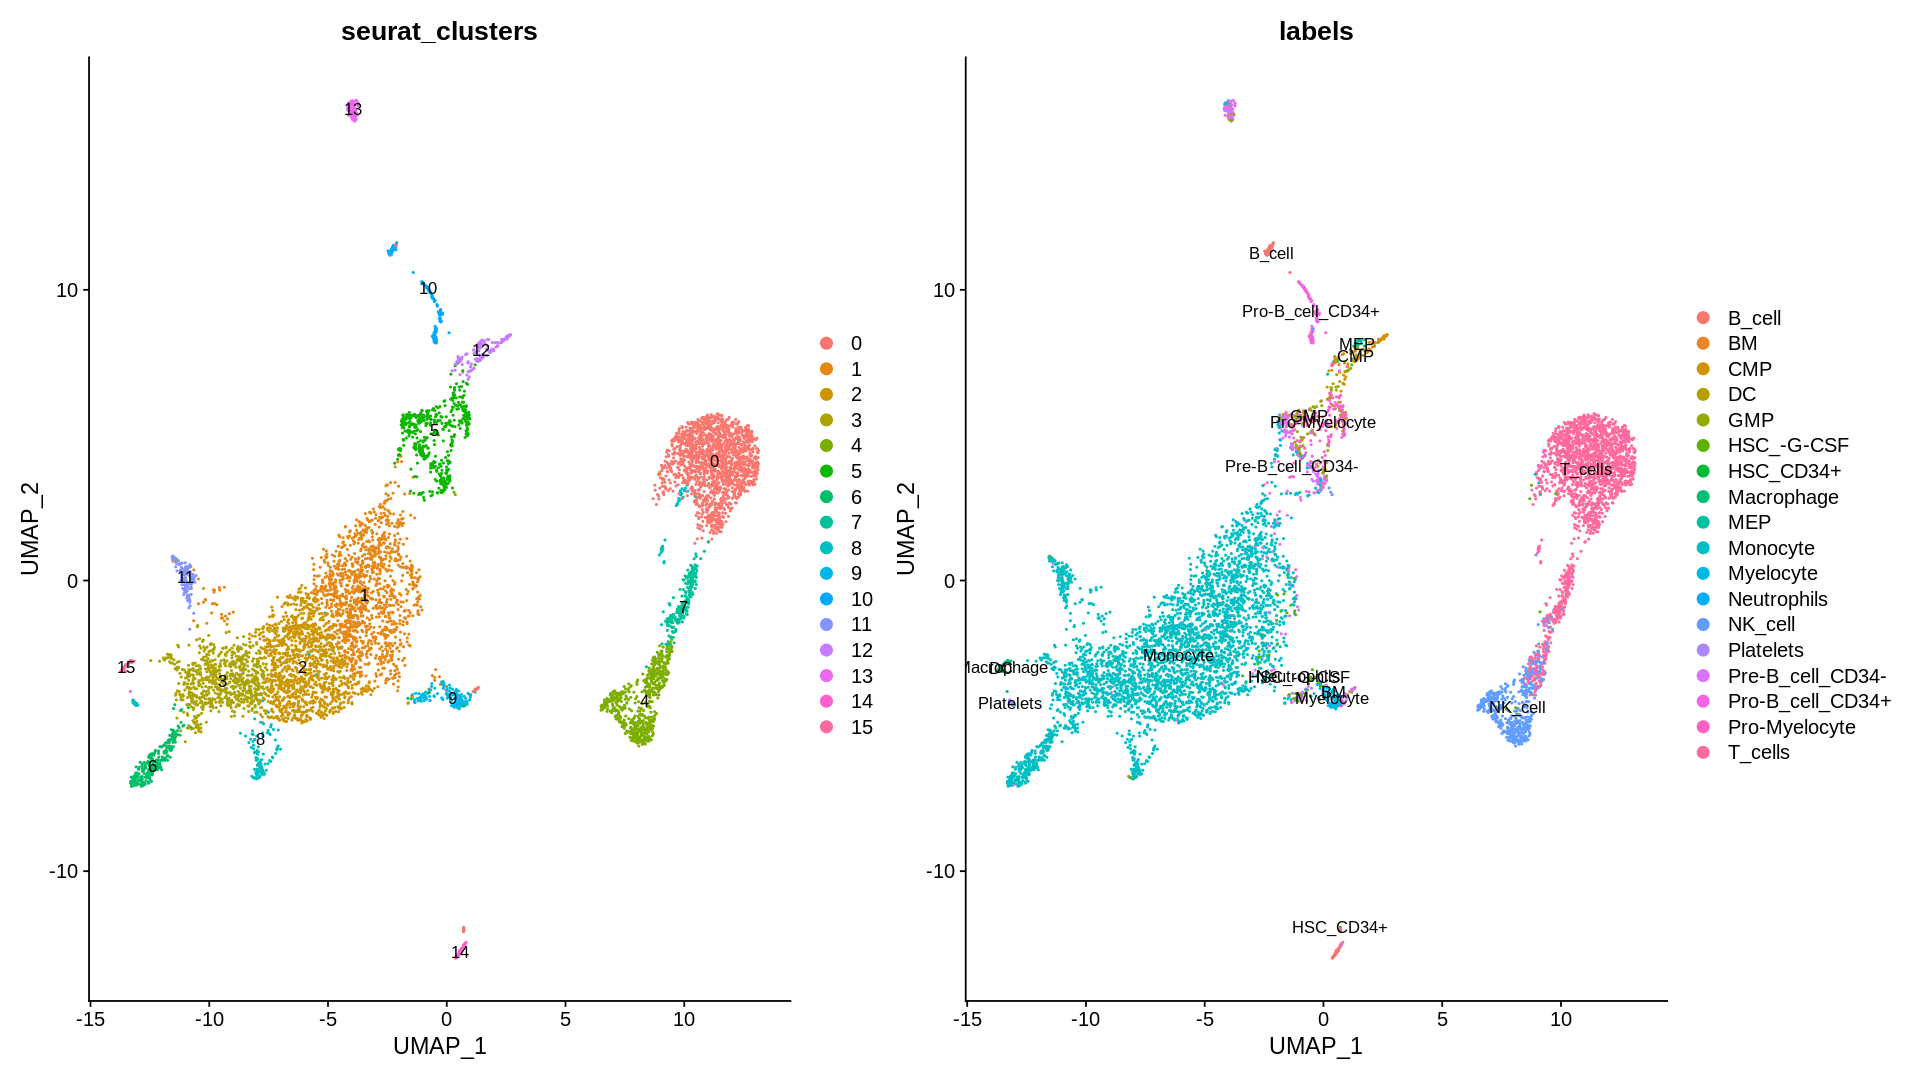

In [55]:
label_plot<-DimPlot(normal2, group.by = c("seurat_clusters","labels"),reduction = "umap",label = TRUE,label.size =3.5)
label_plot

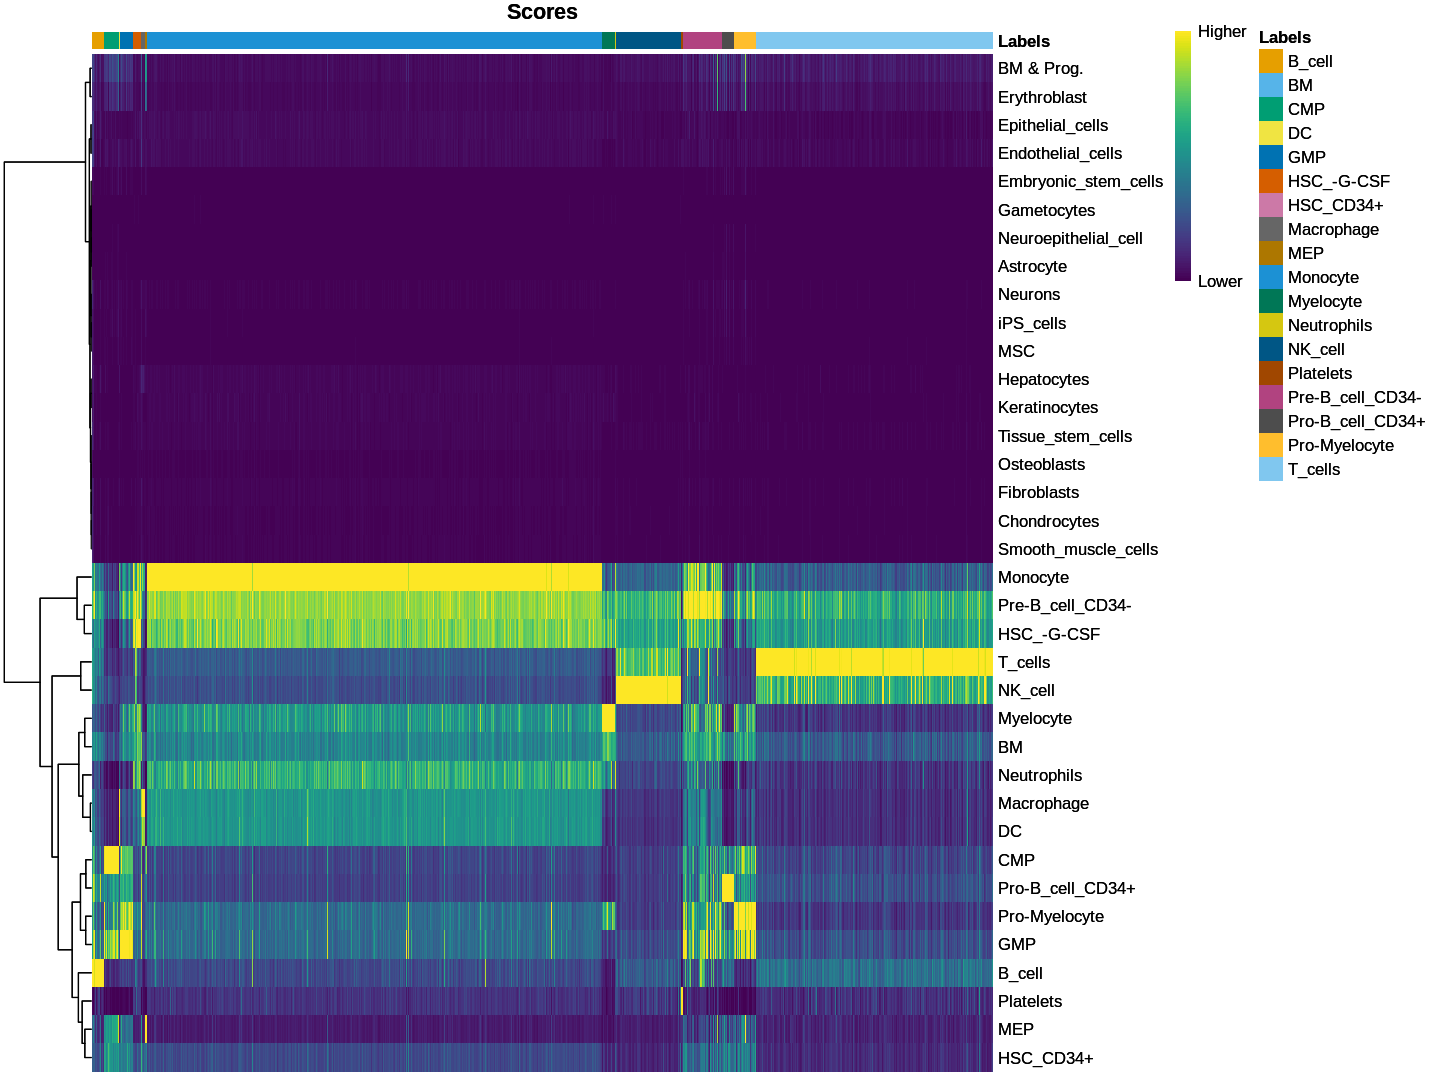

In [56]:
options(repr.plot.height=9,repr.plot.width=12)
plotScoreHeatmap(AL.hesc)

In [57]:
options(repr.plot.height=9,repr.plot.width=16)

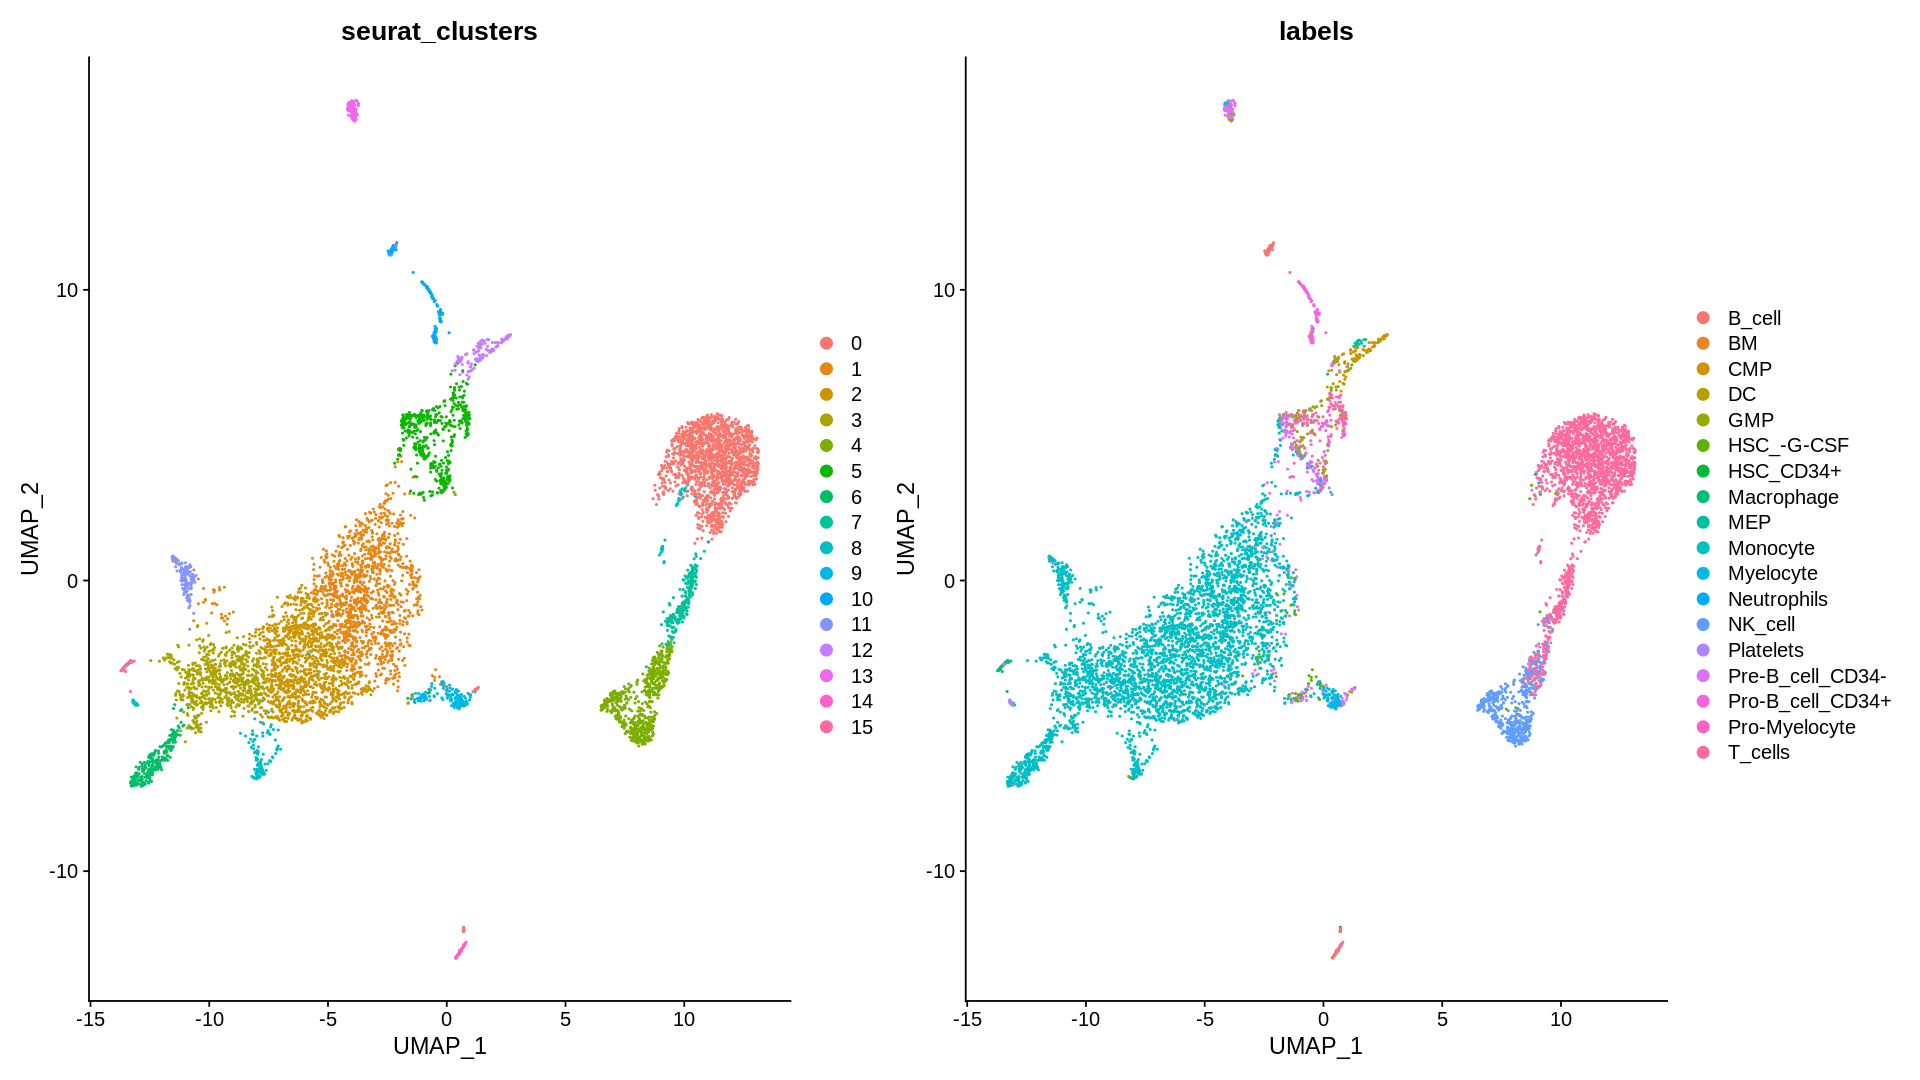

In [58]:
unlabel_plot<-DimPlot(normal2, group.by = c("seurat_clusters","labels"),reduction = "umap")
unlabel_plot

In [59]:
options(repr.plot.height=9,repr.plot.width=7)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



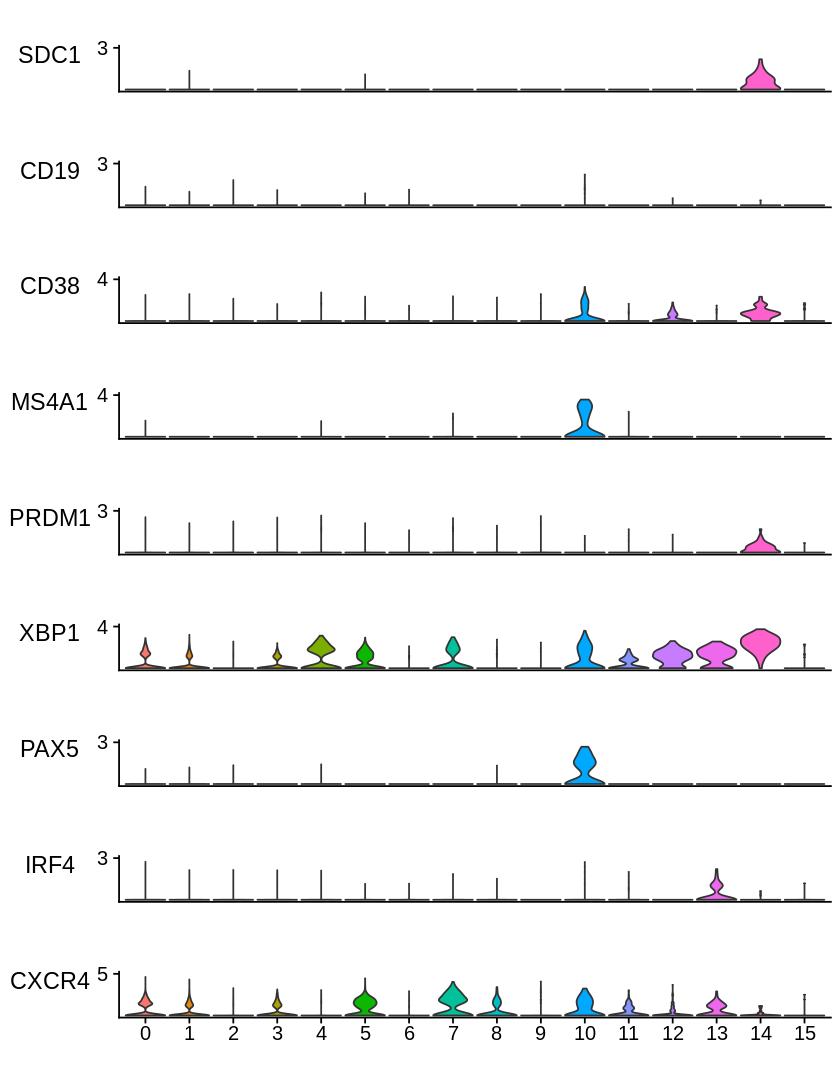

In [60]:
# plasma cell marker
features<- c("SDC1","CD19","CD38","MS4A1","PRDM1","XBP1","PAX5","IRF4","CXCR4")
StackedVlnPlot(obj =normal2, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



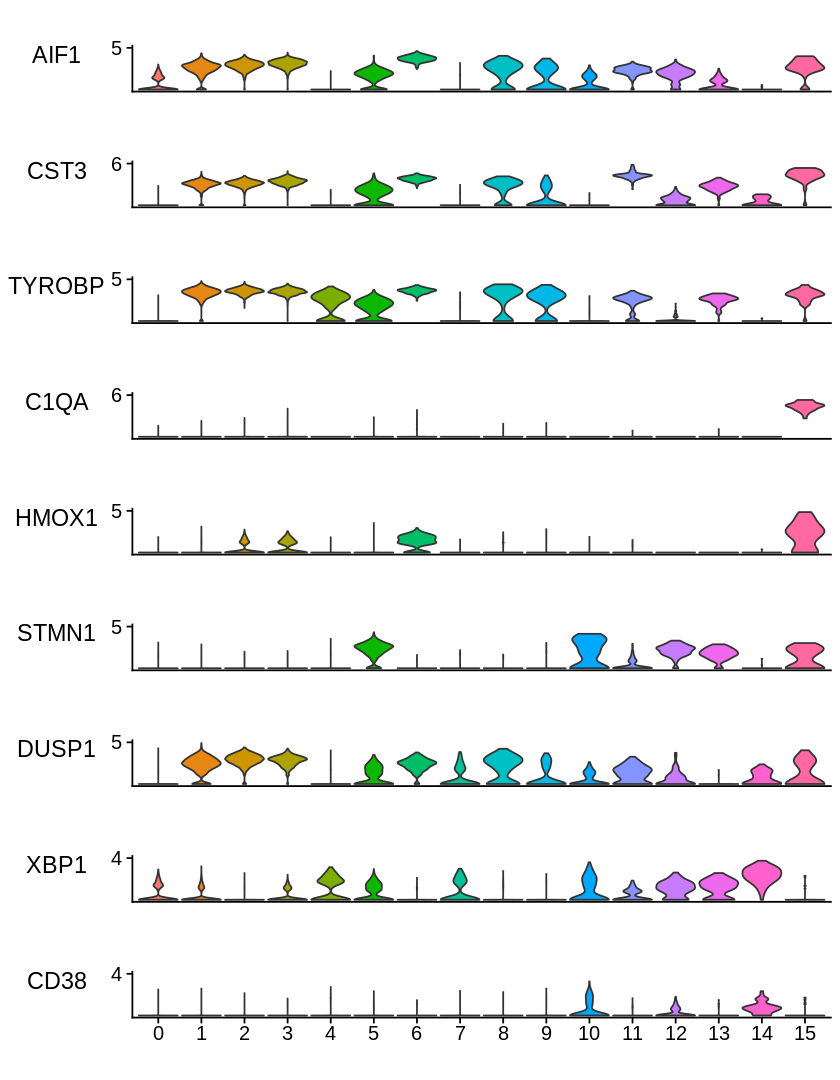

In [61]:
# monocyte?
features<- c("AIF1","CST3","TYROBP","C1QA","HMOX1","STMN1","DUSP1","XBP1","CD38")
StackedVlnPlot(obj =normal2, features = features)

In [62]:
options(repr.plot.height=6,repr.plot.width=6)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



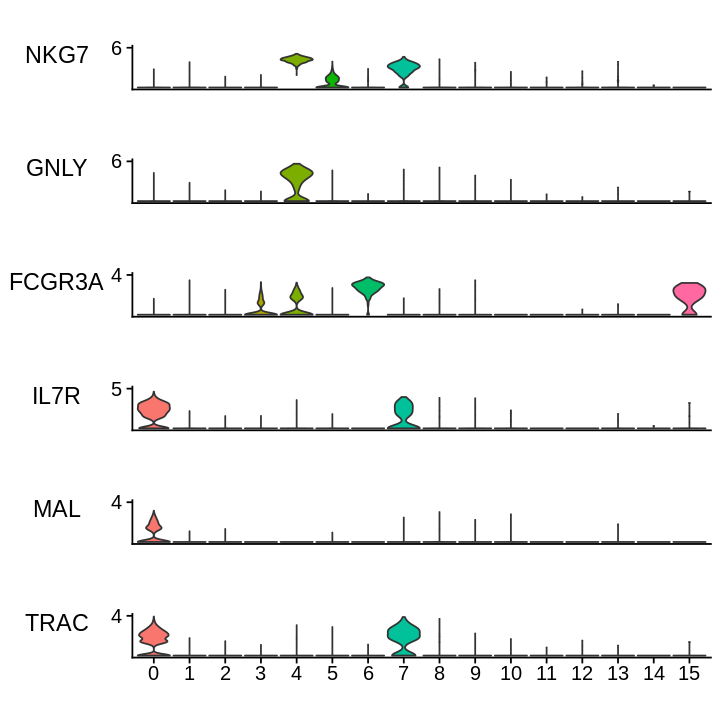

In [63]:
# NK cell
features<- c("NKG7","GNLY","FCGR3A","IL7R","MAL","TRAC")
StackedVlnPlot(obj =normal2, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



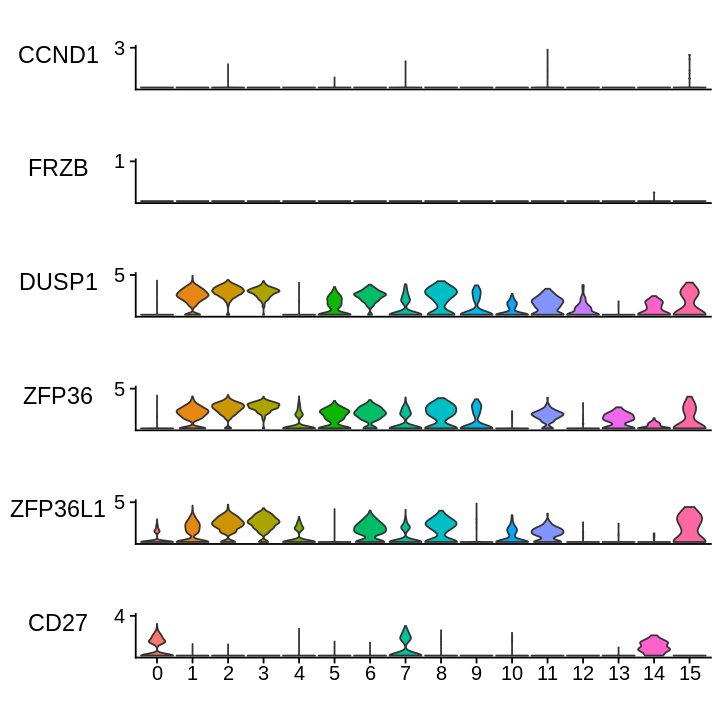

In [64]:
#CCND-dendritic
features<- c("CCND1","FRZB","DUSP1","ZFP36","ZFP36L1","CD27")
StackedVlnPlot(obj =normal2, features = features)

In [65]:
options(repr.plot.height=4,repr.plot.width=8)


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend




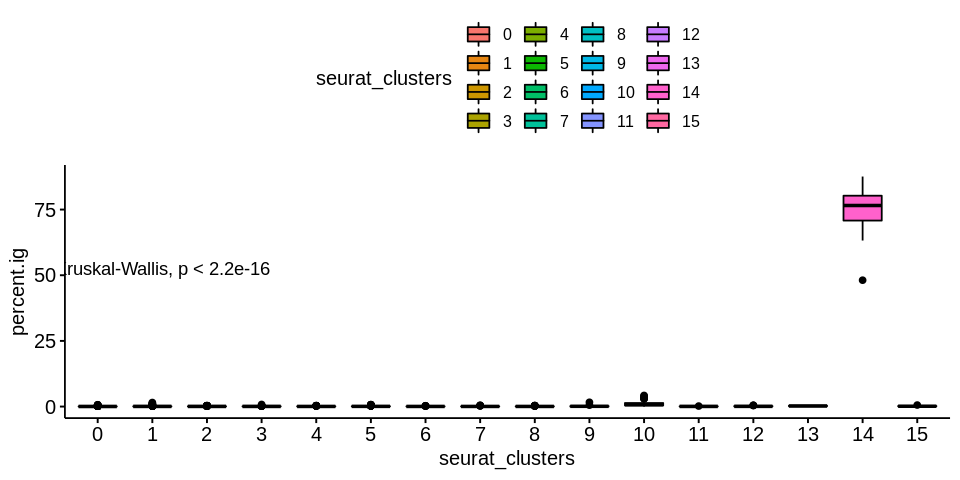

In [66]:
library(ggpubr)
library(RColorBrewer)
ggboxplot(normal2@meta.data, x="seurat_clusters", y="percent.ig", fill = "seurat_clusters")+
  stat_compare_means(label.y = 50)

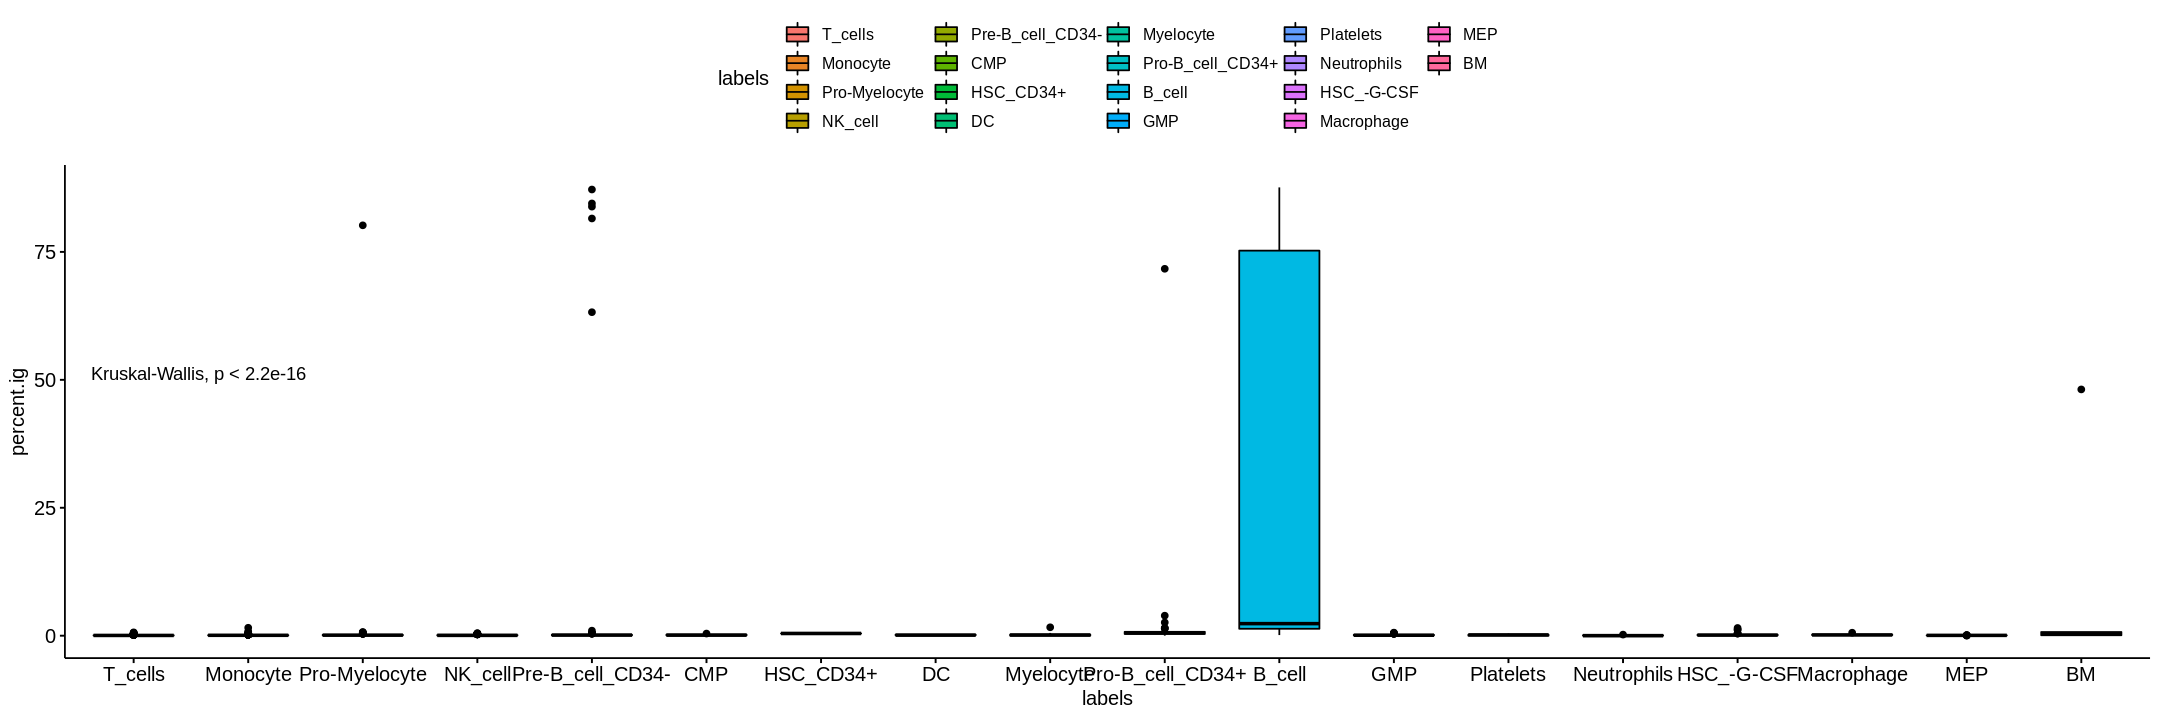

In [67]:
options(repr.plot.height=6,repr.plot.width=18)
ggboxplot(normal2@meta.data, x="labels", y="percent.ig", fill = "labels")+
  stat_compare_means(label.y = 50)

In [68]:
normal3.markers <- FindAllMarkers(normal2, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
normal3.markers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15



p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene    
1   0.000000e+00 3.349358   0.964 0.195  0.000000e+00 0       LTB     
2   0.000000e+00 3.019349   0.802 0.053  0.000000e+00 0       IL7R    
3   0.000000e+00 2.417190   0.782 0.110  0.000000e+00 0       TRBC2   
4   0.000000e+00 2.266262   0.777 0.058  0.000000e+00 0       TRAC    
5   0.000000e+00 2.151890   0.880 0.083  0.000000e+00 0       CD3D    
6   0.000000e+00 2.264988   0.996 0.670  0.000000e+00 1       S100A9  
7   0.000000e+00 1.975314   0.995 0.633  0.000000e+00 1       S100A8  
8   0.000000e+00 1.915975   0.738 0.204  0.000000e+00 1       CYP1B1  
9   0.000000e+00 1.717634   0.961 0.401  0.000000e+00 1       VCAN    
10  0.000000e+00 1.514609   0.958 0.376  0.000000e+00 1       S100A12 
11  0.000000e+00 1.695808   0.915 0.360  0.000000e+00 2       RGS2    
12  0.000000e+00 1.691681   0.947 0.404  0.000000e+00 2       NAMPT   
13  0.000000e+00 1.691656   0.947 0.350  0.000000e+00 2       CD14    
14  0.000000e+00 1.611519   0.999 0.586  0.000000e+00 2       CTSS    
15 6.645321e-303 1.667925   0.832 0.308 1.419773e-298 2       EGR1    
16  0.000000e+00 1.883745   0.944 0.257  0.000000e+00 3       LGALS2  
17  0.000000e+00 1.844225   0.748 0.152  0.000000e+00 3       EGR2    
18 5.034010e-282 2.083705   0.747 0.182 1.075516e-277 3       IL1B    
19 9.026775e-279 1.697231   0.984 0.410 1.928570e-274 3       DUSP6   
20 2.341842e-227 1.732104   0.678 0.171 5.003346e-223 3       PTGS2   
21  0.000000e+00 5.298505   0.715 0.016  0.000000e+00 4       GNLY    
22  0.000000e+00 4.971511   1.000 0.147  0.000000e+00 4       NKG7    
23  0.000000e+00 4.009914   0.936 0.087  0.000000e+00 4       CCL5    
24  0.000000e+00 3.886464   0.978 0.054  0.000000e+00 4       GZMA    
25  0.000000e+00 3.846751   0.928 0.015  0.000000e+00 4       KLRD1   
26  0.000000e+00 5.760224   0.852 0.125  0.000000e+00 5       MPO     
27  0.000000e+00 3.905439   0.781 0.135  0.000000e+00 5       AZU1    
28 3.474913e-253 4.367820   0.656 0.121 7.424152e-249 5       ELANE   
29 1.170491e-166 4.649716   0.555 0.130 2.500754e-162 5       PRTN3   
30  6.659997e-04 3.464723   0.373 0.409  1.000000e+00 5       DEFA3   
⋮  ⋮             ⋮          ⋮     ⋮     ⋮             ⋮       ⋮       
51  0.000000e+00 4.375016   0.779 0.004  0.000000e+00 10      VPREB3  
52  0.000000e+00 4.251656   0.634 0.005  0.000000e+00 10      VPREB1  
53  0.000000e+00 3.818638   0.572 0.002  0.000000e+00 10      DNTT    
54 8.319565e-297 4.297964   0.614 0.027 1.777475e-292 10      IGLL1   
55 1.980066e-275 3.332430   0.855 0.068 4.230412e-271 10      CD79B   
56 1.557784e-170 3.768231   1.000 0.187 3.328205e-166 11      HLA-DQA1
57 7.436193e-147 3.366502   1.000 0.222 1.588743e-142 11      HLA-DQB1
58 9.049190e-103 3.401025   1.000 0.418  1.933360e-98 11      HLA-DPB1
59  6.795571e-99 3.314161   1.000 0.456  1.451874e-94 11      HLA-DPA1
60  6.406094e-98 3.327494   1.000 0.465  1.368662e-93 11      HLA-DRB1
61  0.000000e+00 2.683079   0.756 0.014  0.000000e+00 12      SPINK2  
62  0.000000e+00 2.140436   0.359 0.001  0.000000e+00 12      AVP     
63 6.002567e-241 2.035619   0.603 0.029 1.282448e-236 12      IGLL1   
64 4.031710e-120 1.987736   0.954 0.180 8.613748e-116 12      STMN1   
65  1.607734e-83 2.443112   1.000 0.749  3.434923e-79 12      SNHG29  
66 5.964366e-225 3.593937   0.971 0.088 1.274287e-220 13      UGCG    
67 3.607250e-189 3.493217   0.961 0.109 7.706890e-185 13      CCDC50  
68 9.456710e-174 3.723466   0.971 0.123 2.020426e-169 13      TCF4    
69 5.622740e-160 3.505176   0.990 0.147 1.201298e-155 13      IRF8    
70  1.266196e-92 3.679932   0.252 0.011  2.705227e-88 13      PTGDS   
71 4.686192e-110 8.808562   0.938 0.073 1.001205e-105 14      IGLC1   
72  6.488865e-34 8.960922   0.500 0.067  1.386346e-29 14      IGLC3   
73  2.793223e-26 8.572535   0.604 0.119  5.967721e-22 14      IGHA1   
74  1.099805e-22 9.956597   0.750 0.191  2.349734e-18 14      IGLC2   
75  2.868110e-12 9.788916  

In [69]:
options(repr.plot.height=10,repr.plot.width=10)

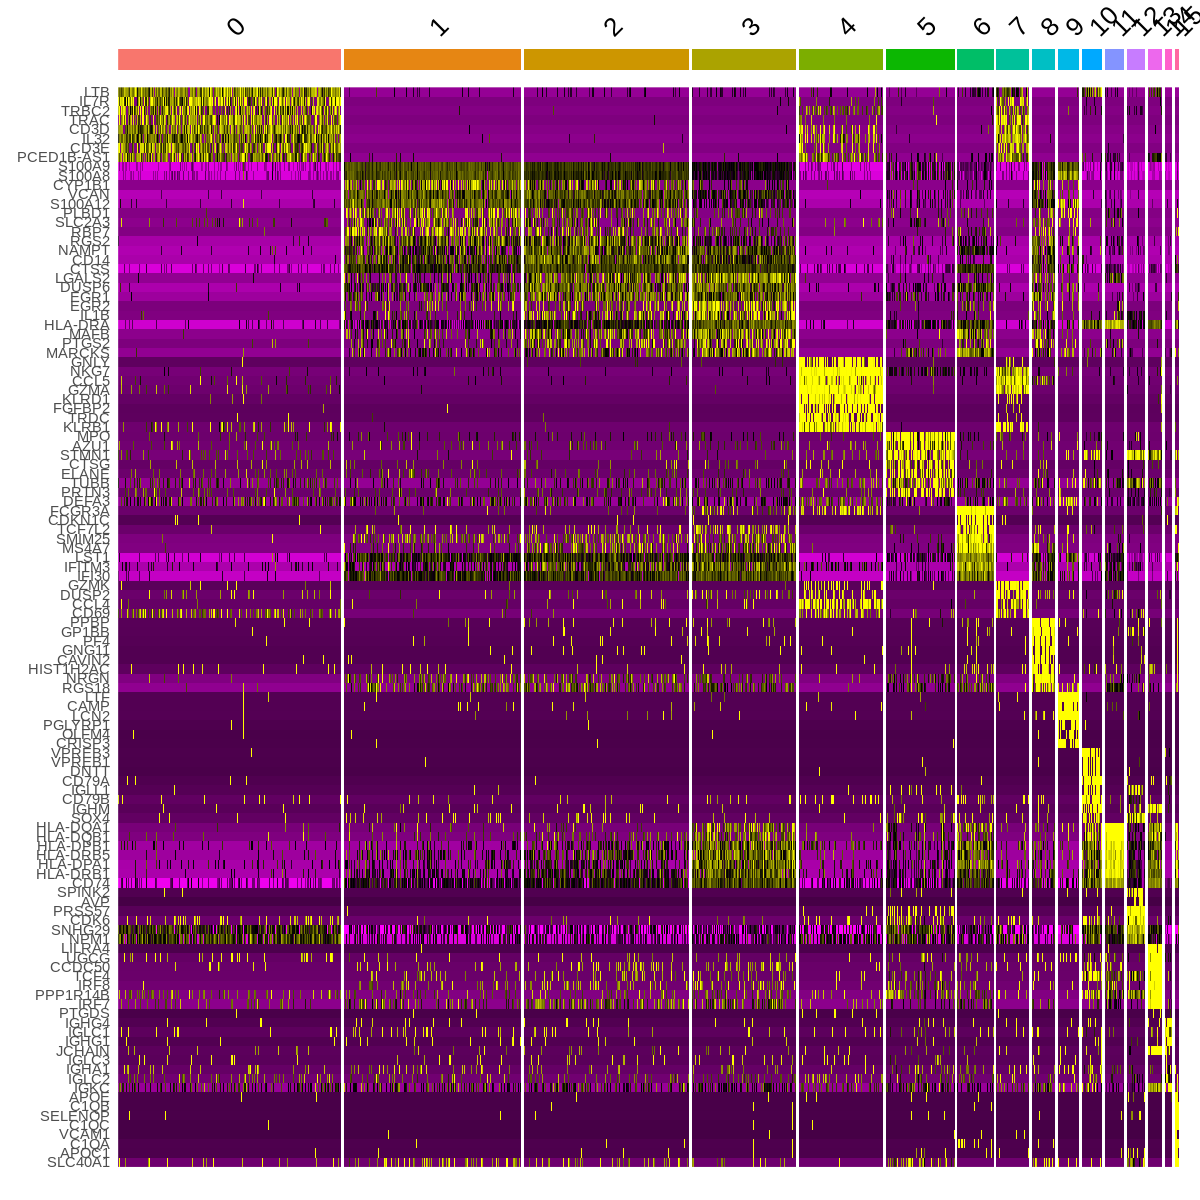

In [70]:
top10 <- normal3.markers %>% group_by(cluster) %>% top_n(n = 8, wt = avg_log2FC)
DoHeatmap(normal2, features = top10$gene) + NoLegend()

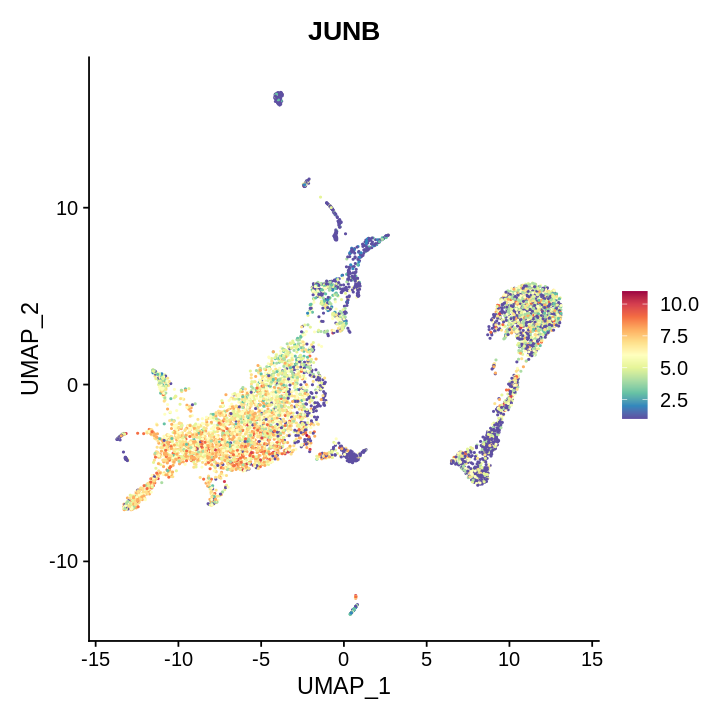

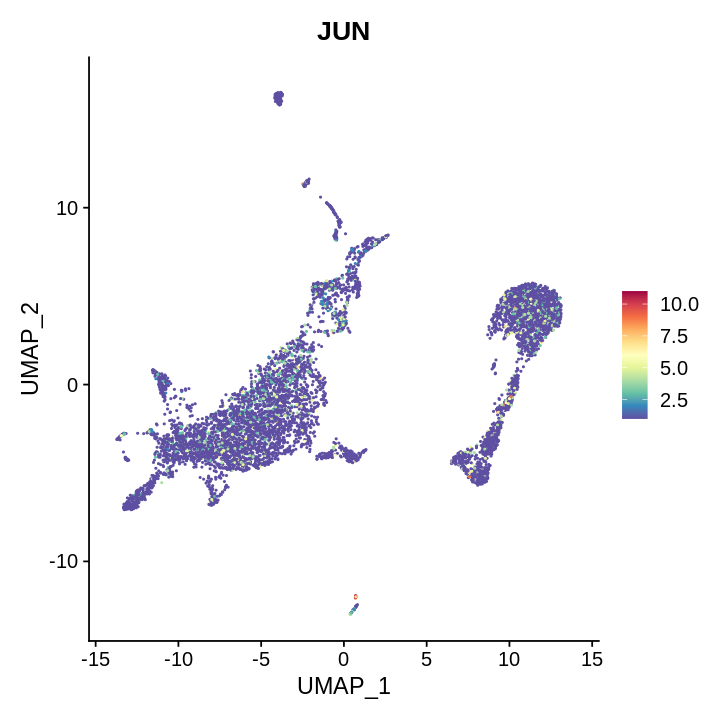

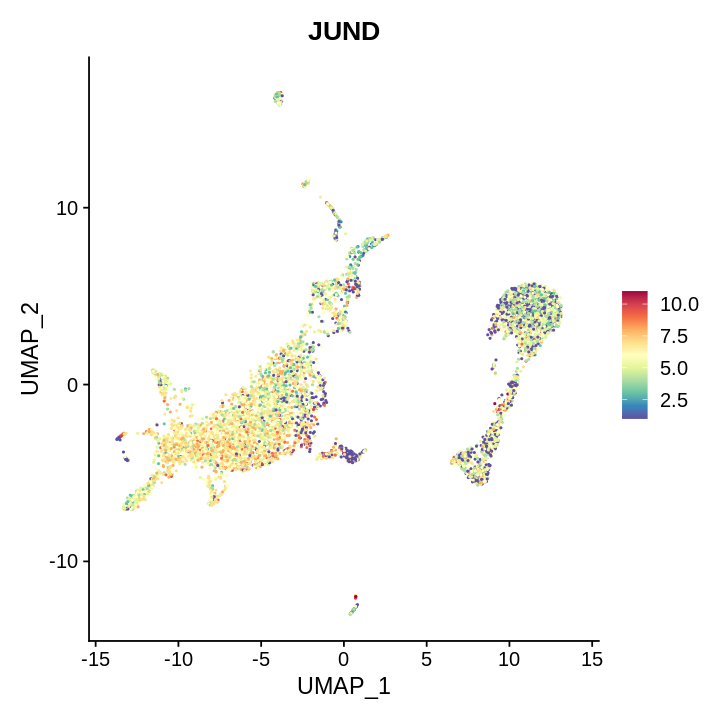

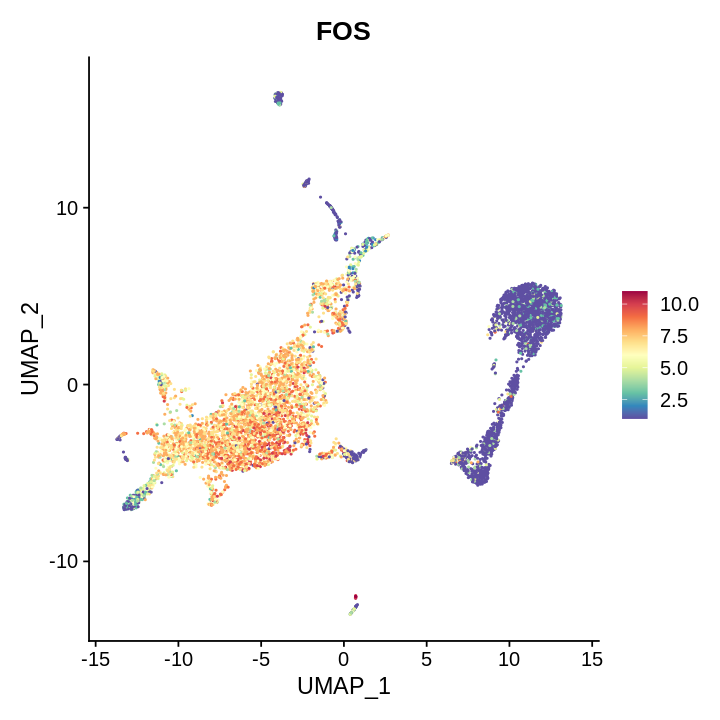

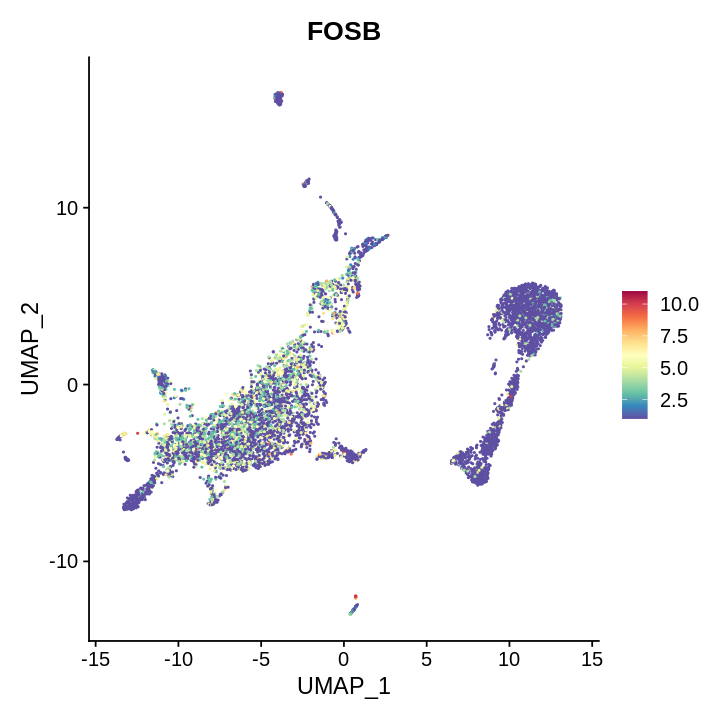

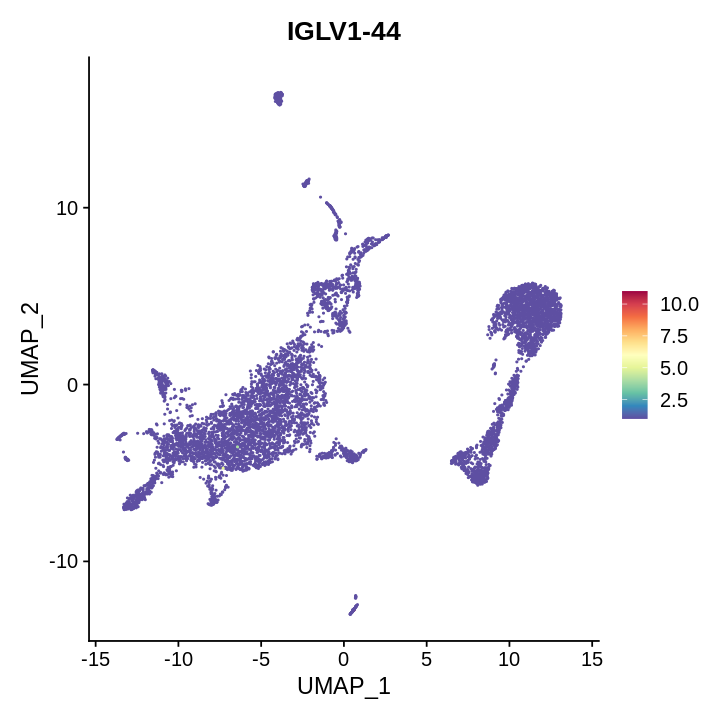

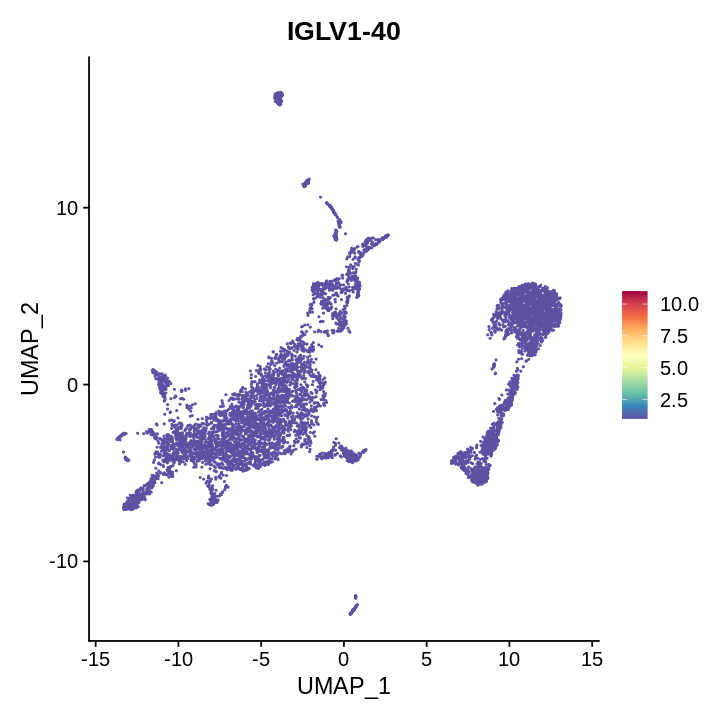

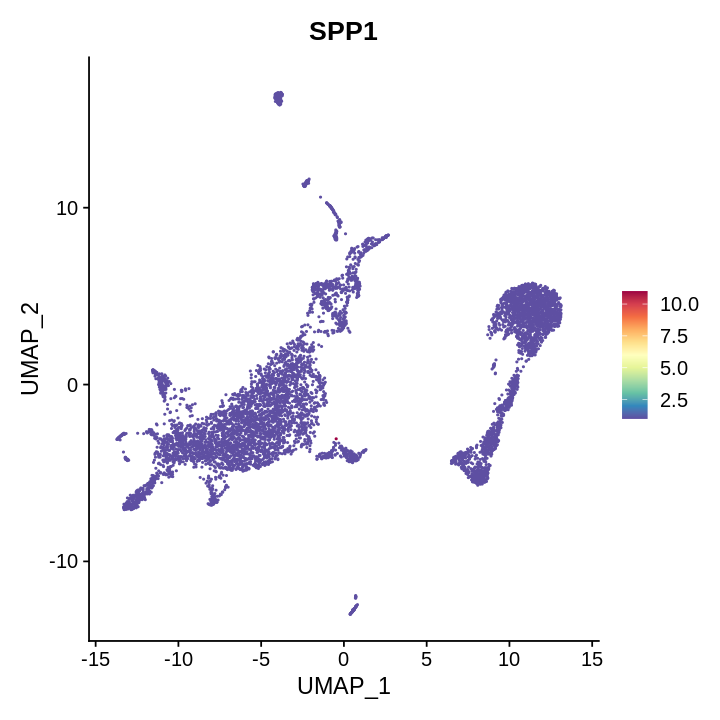

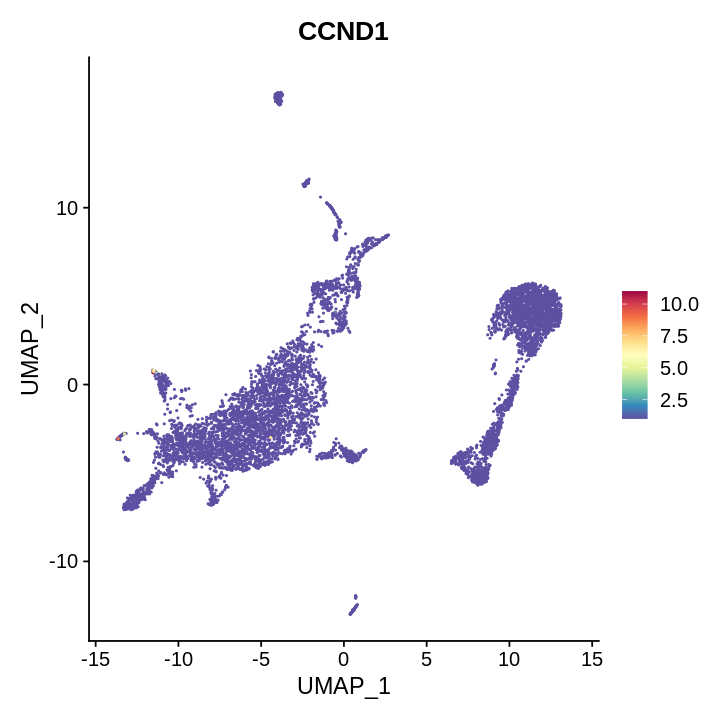

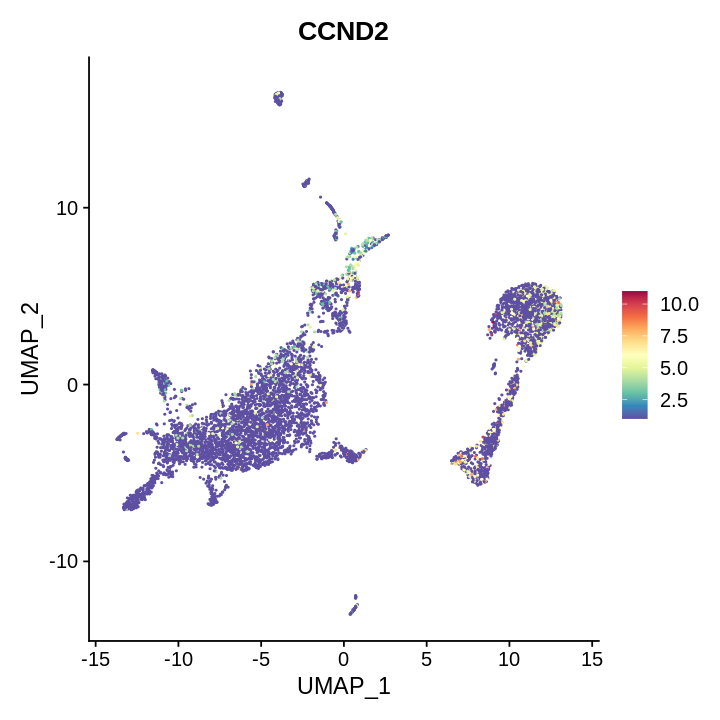

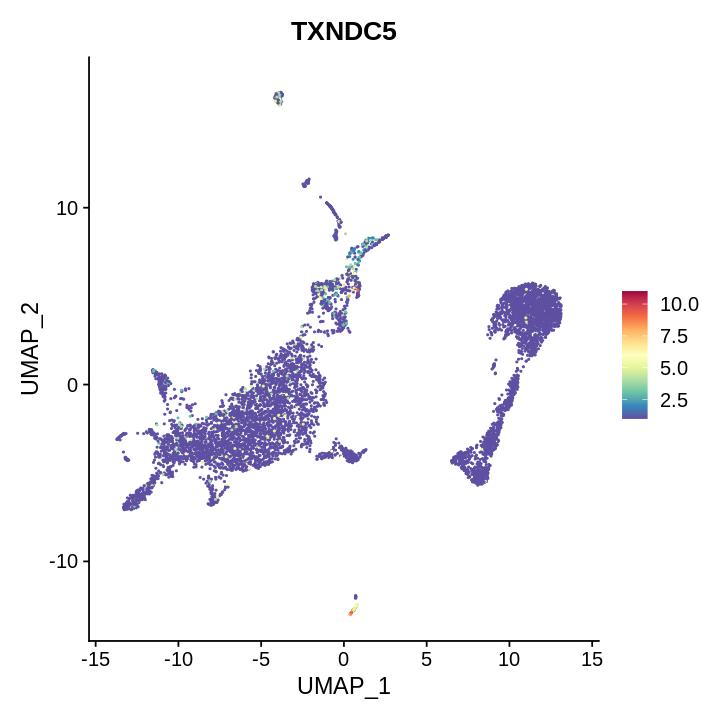

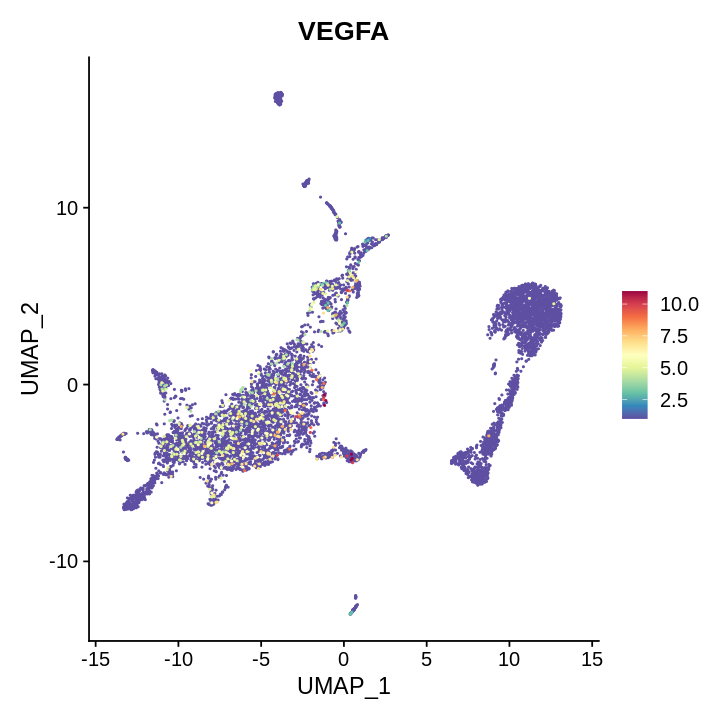

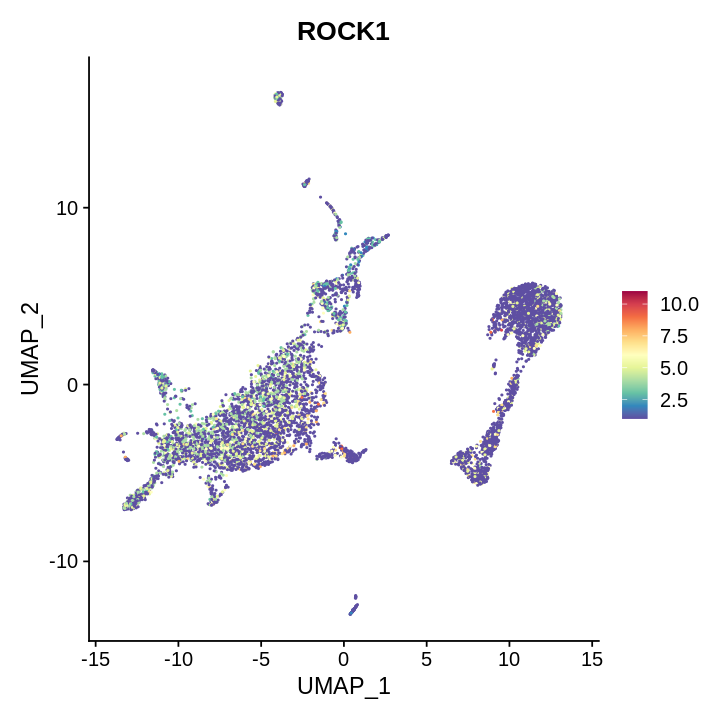

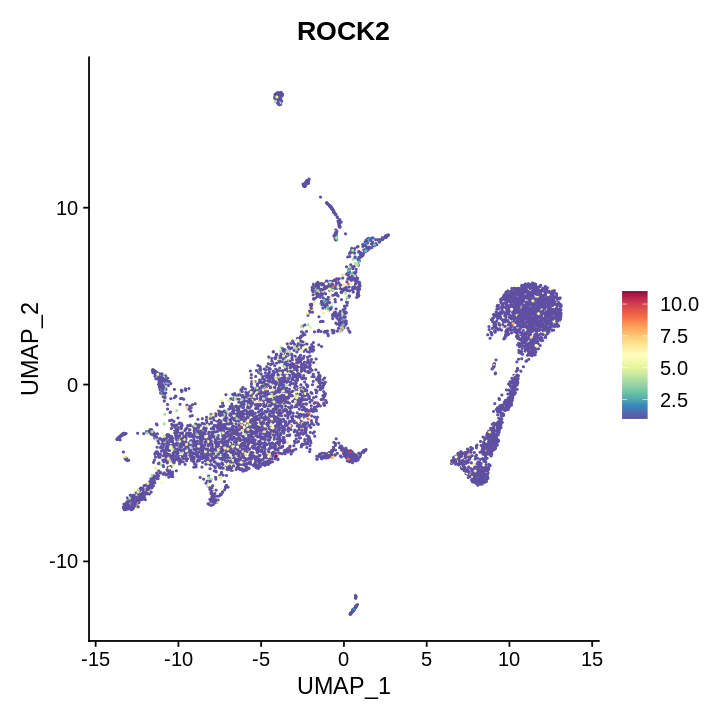

In [71]:
options(repr.plot.height=6,repr.plot.width=6)
FeaturePlot(normal2, features = c('JUNB'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('JUN'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('JUND'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('FOS'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('FOSB'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('IGLV1-44'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('IGLV1-40'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('SPP1'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('CCND1'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('CCND2'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('TXNDC5'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('VEGFA'),order=TRUE,cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('ROCK1'),cols=rev(brewer.pal(11,'Spectral')))
FeaturePlot(normal2, features = c('ROCK2'),cols=rev(brewer.pal(11,'Spectral')))

In [72]:
save(normal2,file="0830-MGUS1-3.Rda")

In [ ]:
normal2